# Loading Libraries

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.pandas.set_option('display.max_columns',None)

import seaborn as sns
import scipy.stats as stat
import pylab
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import joblib
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import scipy.stats as stat
import pylab

import warnings
warnings.filterwarnings("ignore")

# Agenda

1. Use Variance Threshold to see which features have minimal variance

2. Corelation Analysis

3. Mutual Information Analysis

4. Chi Square Analysis

5. Model Based Methods (Random Forests, Lasso)

6. Transformations(Log, Reciprocal, Box Cox etc) on selected features

7. Final Pipeline

# Loading the data

In [2]:
base_url = "sample_data/"
os.listdir(base_url)

df = pd.read_csv('dataset_full.csv')

# EDA

In [3]:
df.shape

(88647, 112)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88647 entries, 0 to 88646
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 75.7 MB


# handle missing vals-

In [5]:
df.isnull().sum()

qty_dot_url             0
qty_hyphen_url          0
qty_underline_url       0
qty_slash_url           0
qty_questionmark_url    0
                       ..
qty_redirects           0
url_google_index        0
domain_google_index     0
url_shortened           0
phishing                0
Length: 112, dtype: int64

In [6]:
df.isnull().sum().sum()

0

In [7]:
# Impute missing values with mean for numerical features
numerical_features = [feature for feature in df.columns if df[feature].dtype!='O']
print(len(numerical_features))
# all features are numerical

112


In [8]:
[df[numerical_feature].fillna(df[numerical_feature].mean(), inplace=True) for numerical_feature in numerical_features]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
df.isnull().sum().sum()

0

# duplicates

In [10]:
df.duplicated().sum()

1438

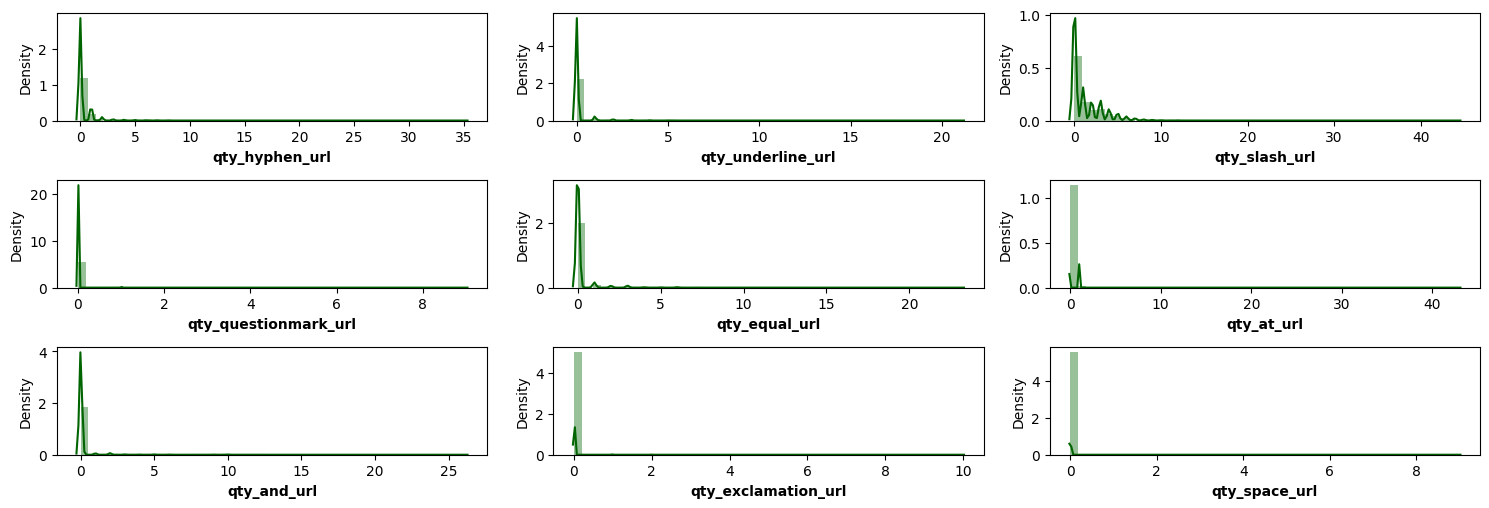

In [11]:
# let's have a look at the distribution first 5 features

plt.figure(figsize=(15, 100))

for i, col in enumerate(df.columns[1:10]):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='darkgreen')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

# Numerical Features -

1. Continuous Features

2. Discrete Features

In [12]:
discrete_features = [feature for feature in df.columns if len(df[feature].unique())<=25]

In [13]:
continuous_features = list(set(numerical_features) - set(discrete_features))

In [14]:
len(discrete_features)+len(continuous_features)

112

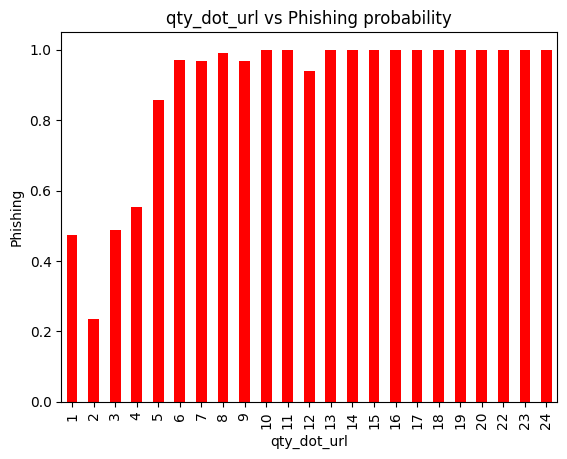

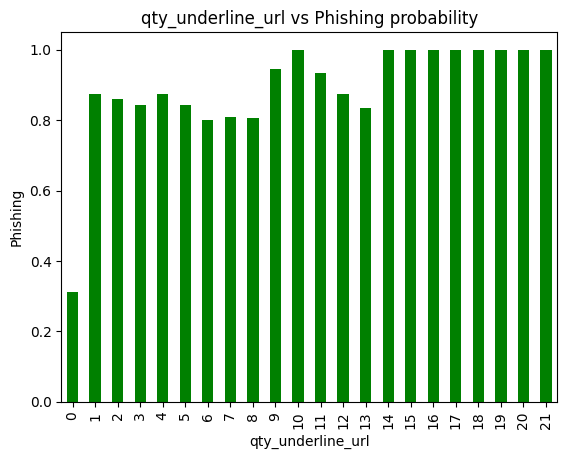

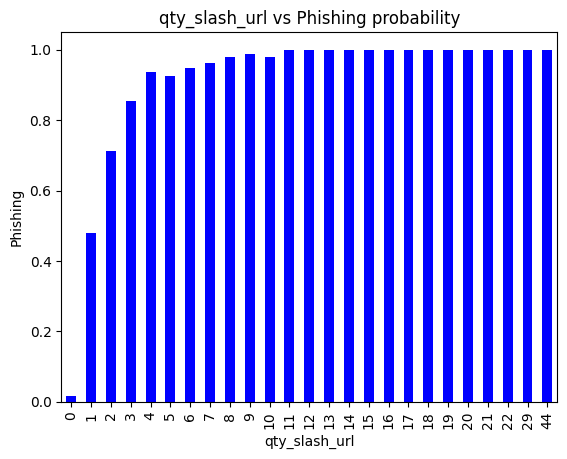

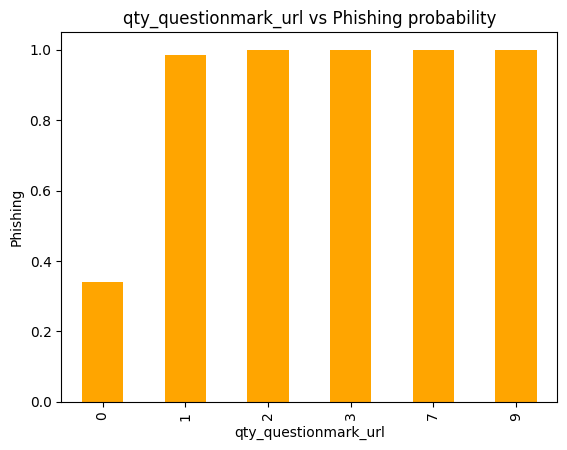

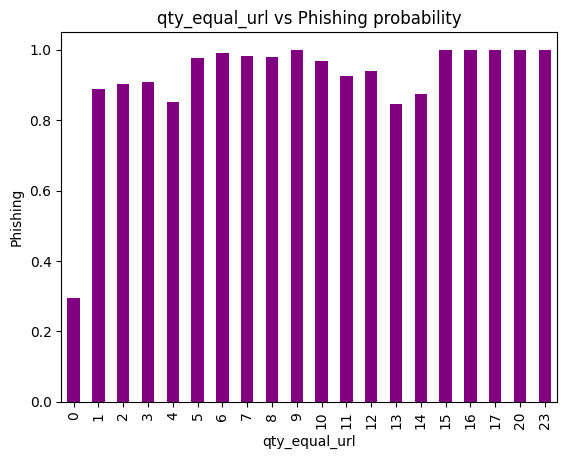

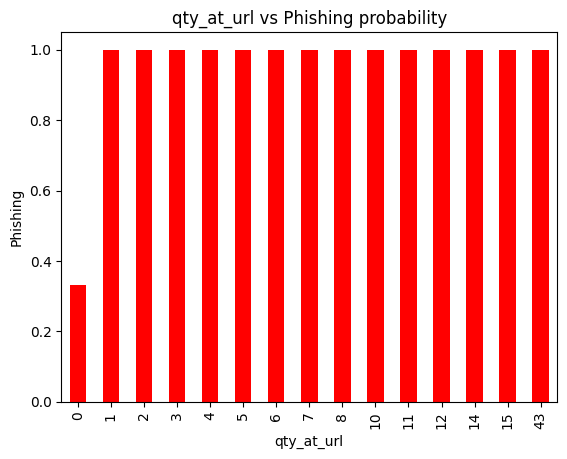

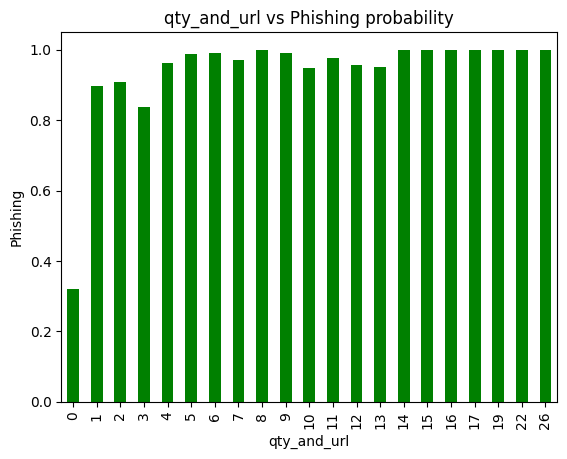

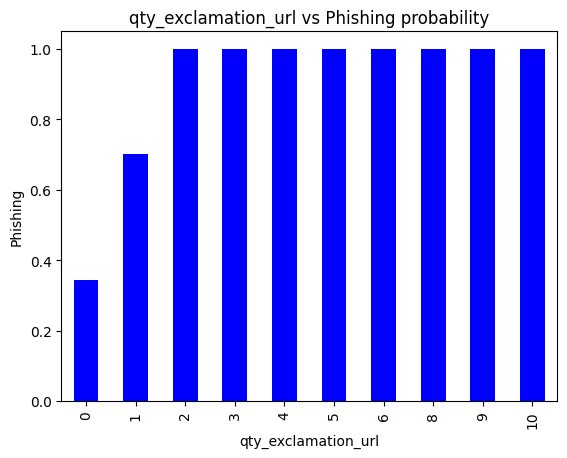

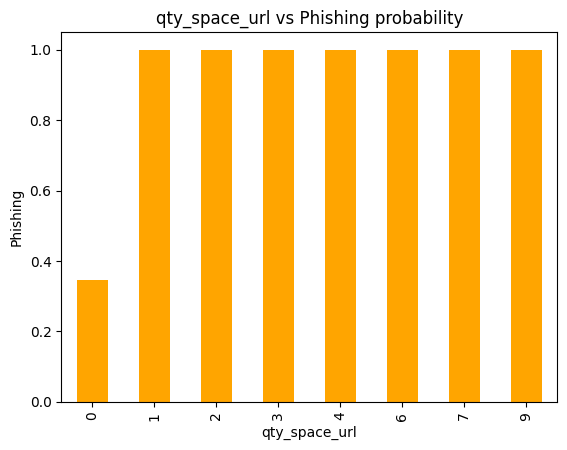

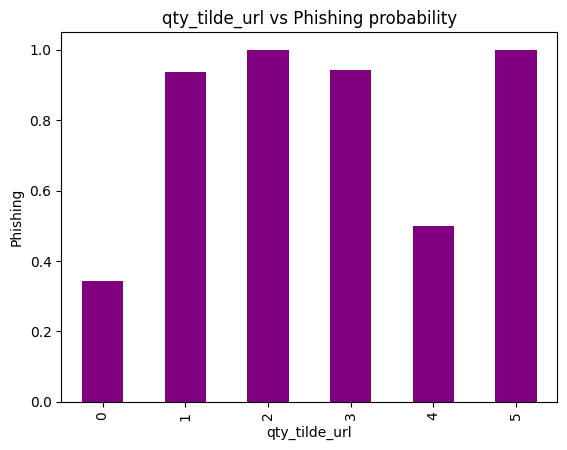

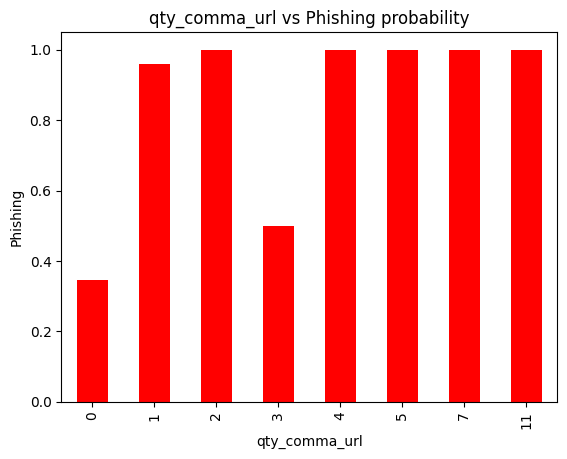

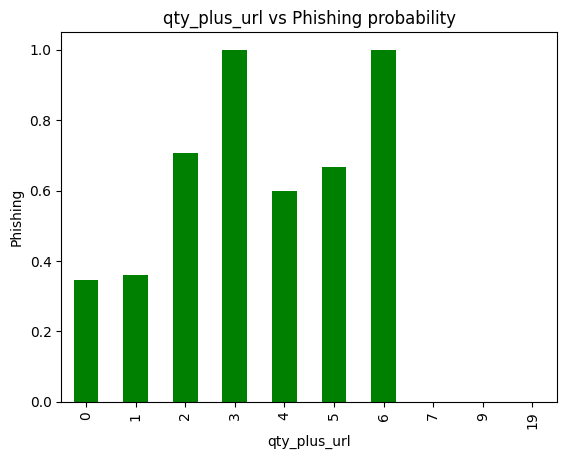

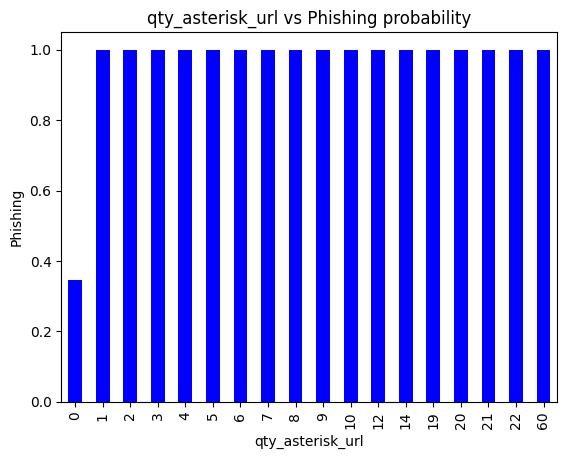

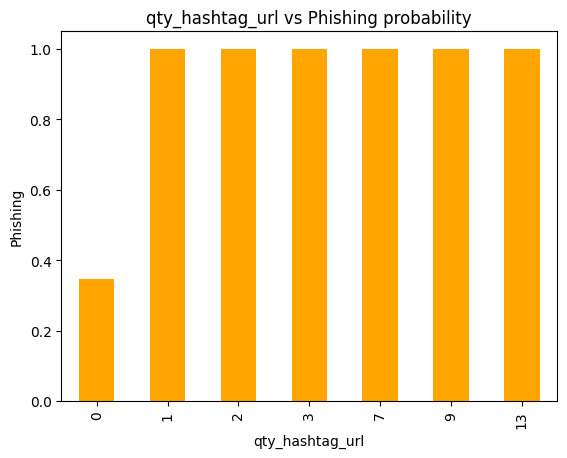

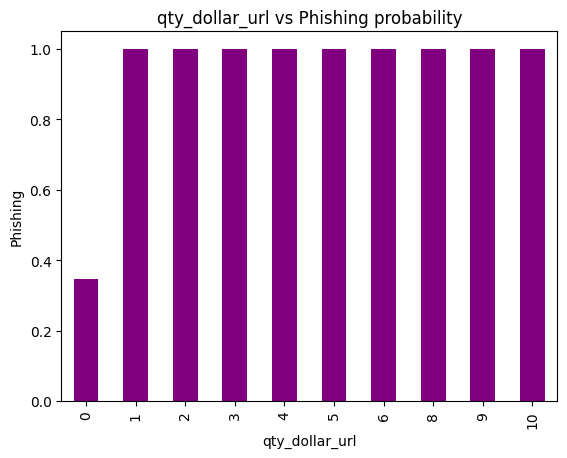

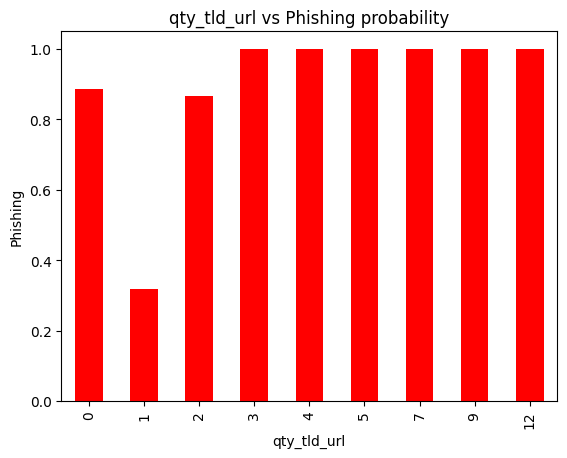

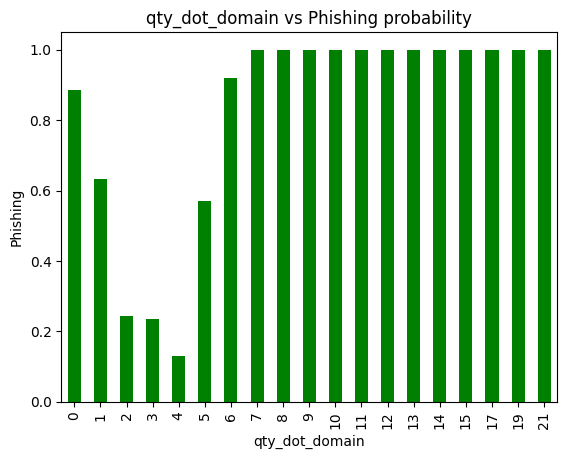

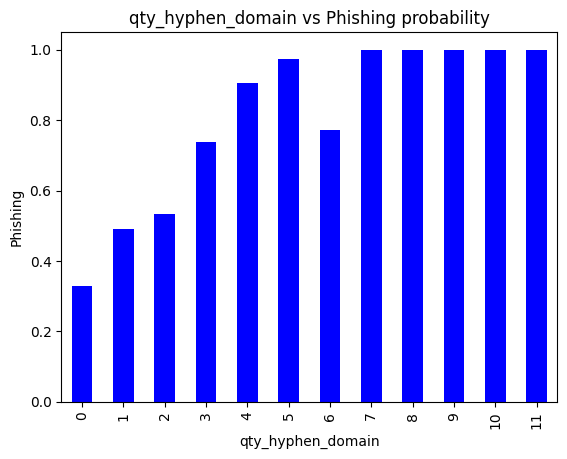

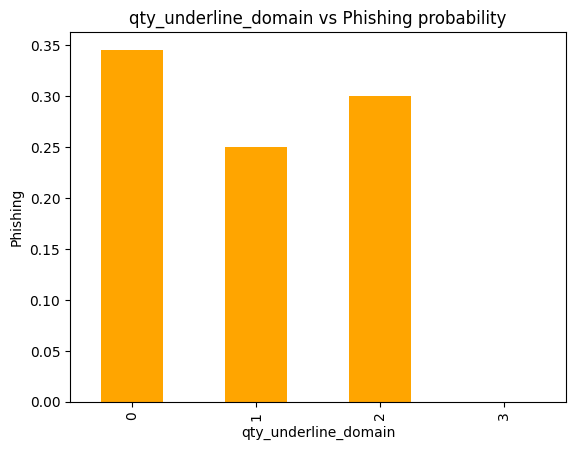

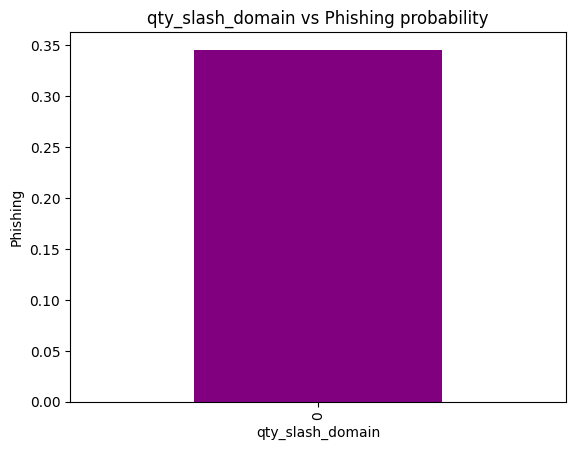

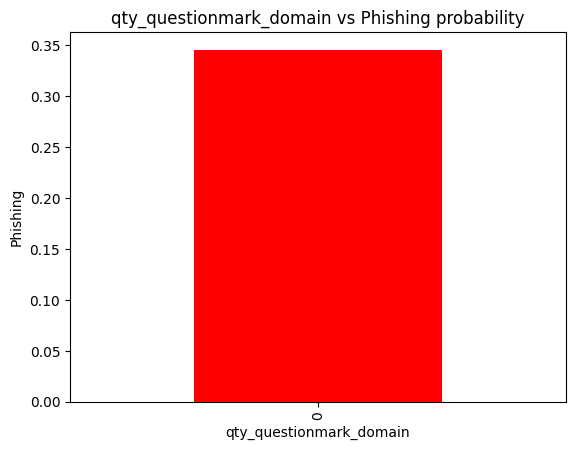

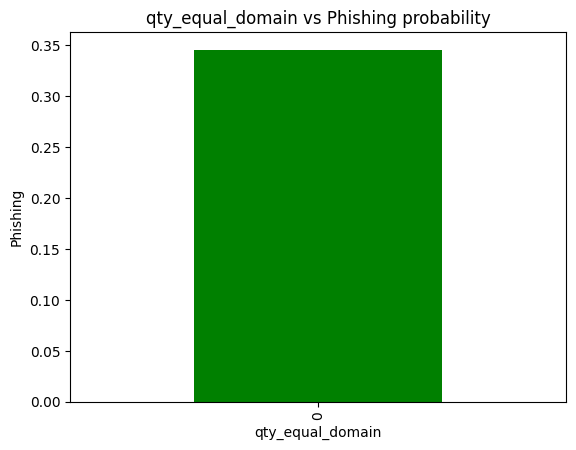

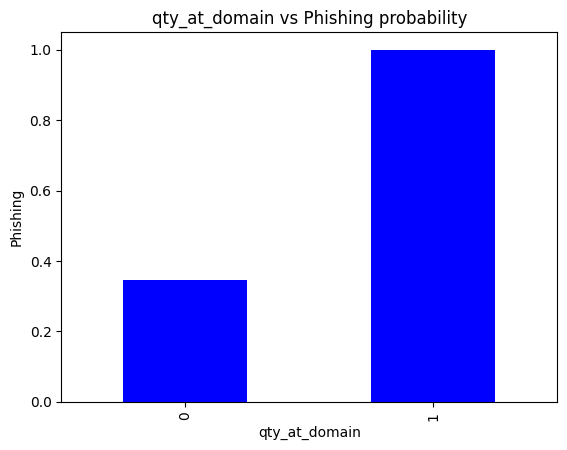

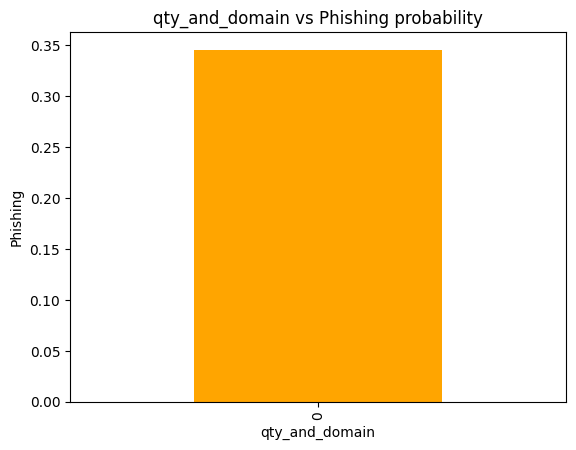

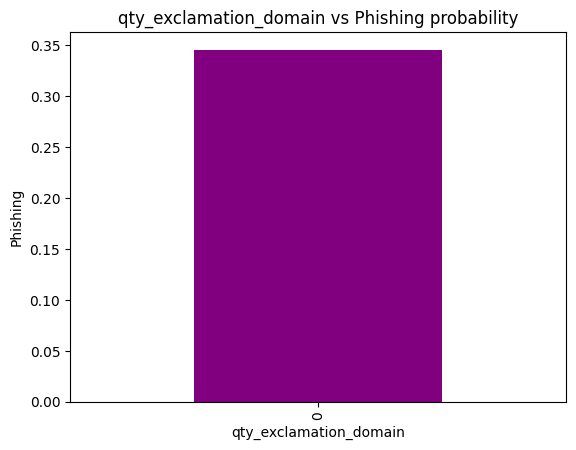

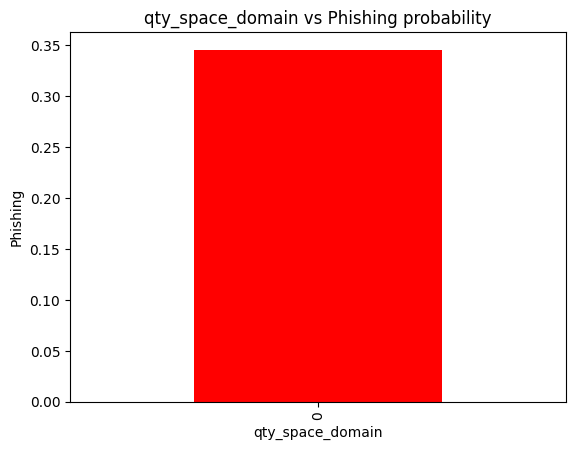

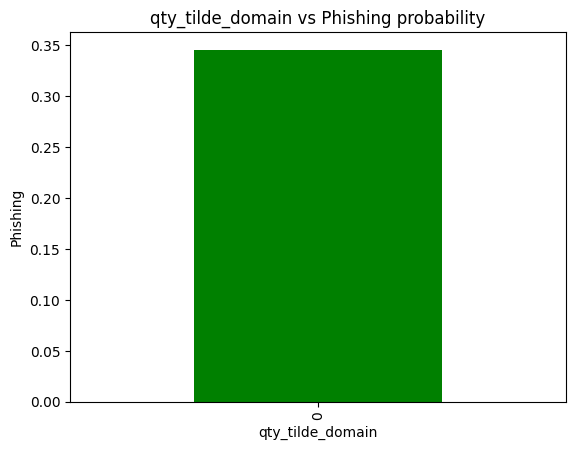

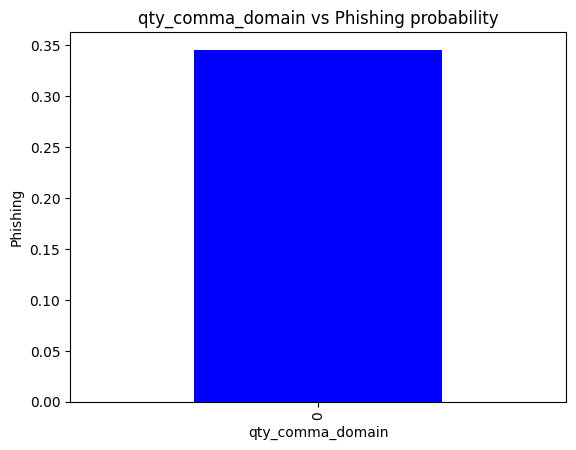

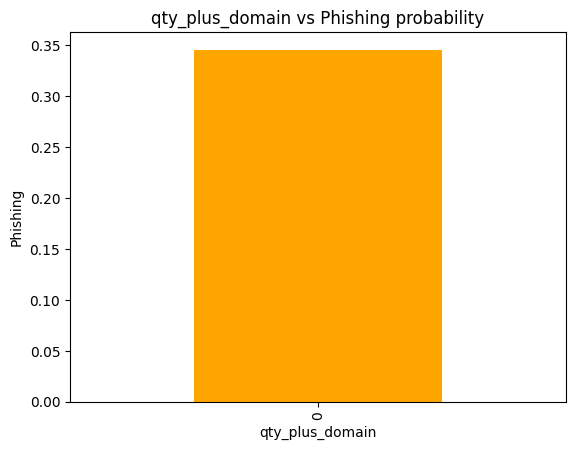

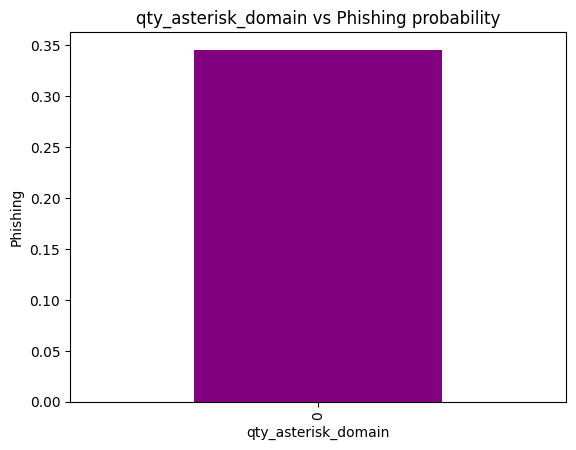

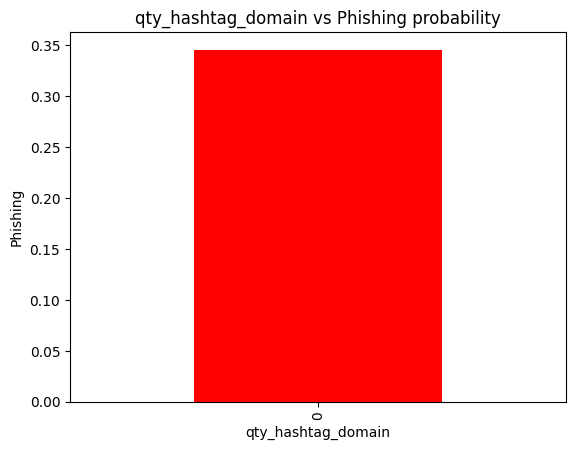

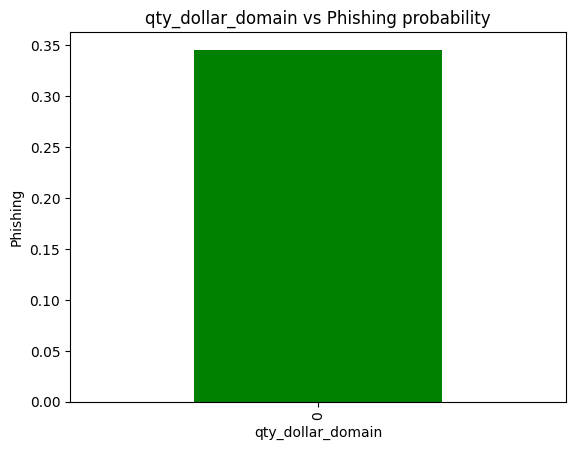

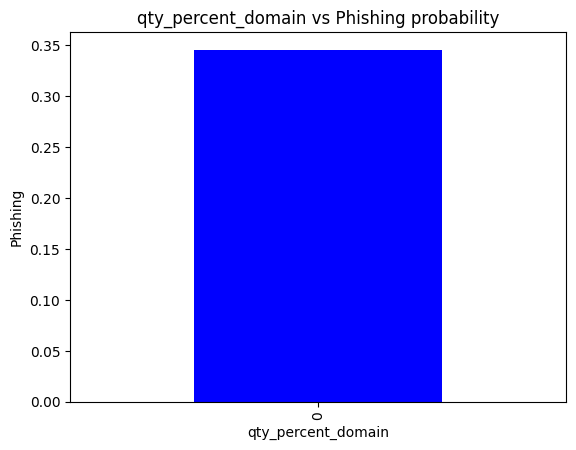

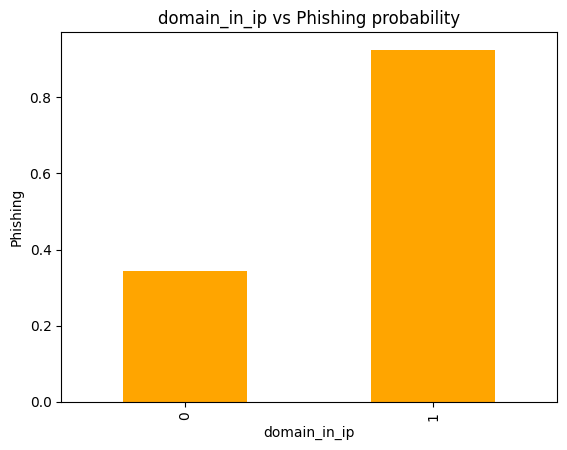

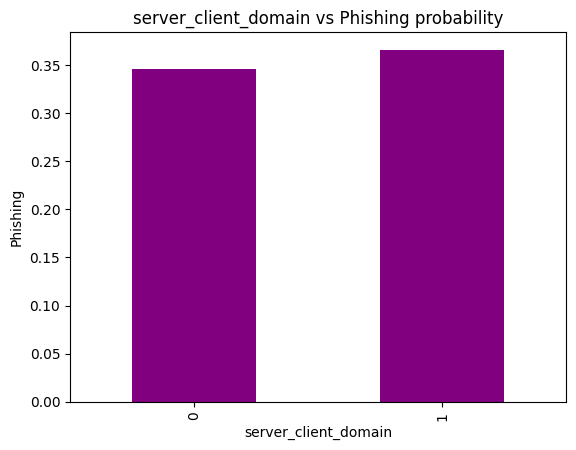

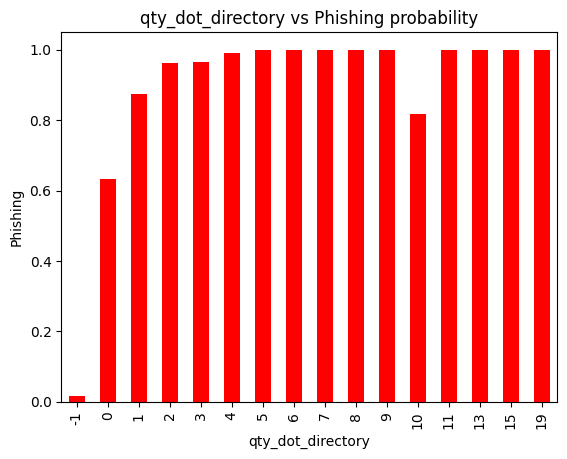

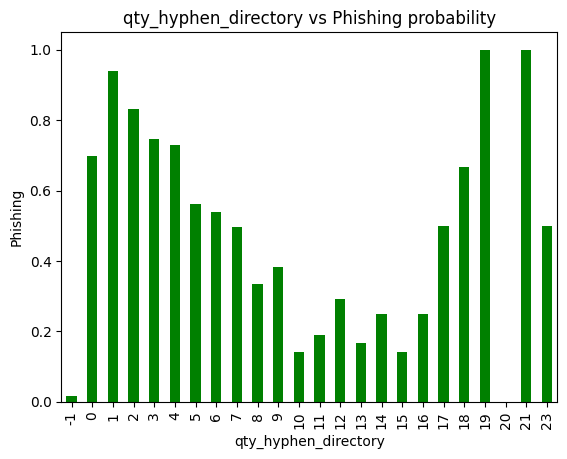

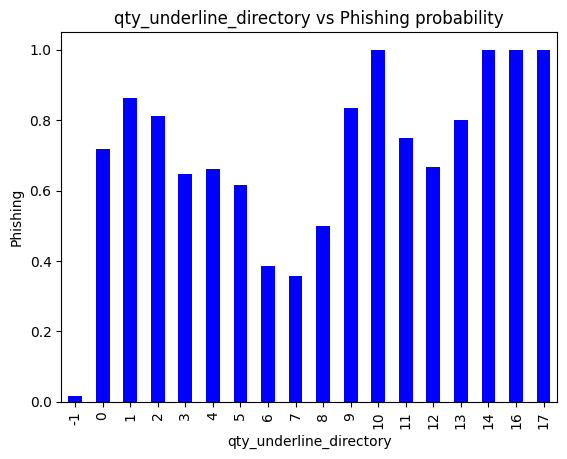

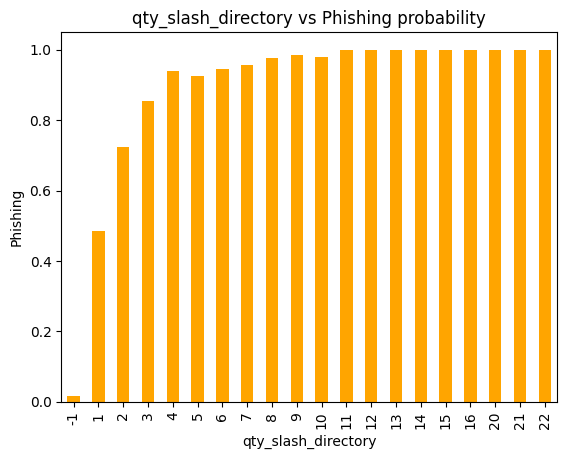

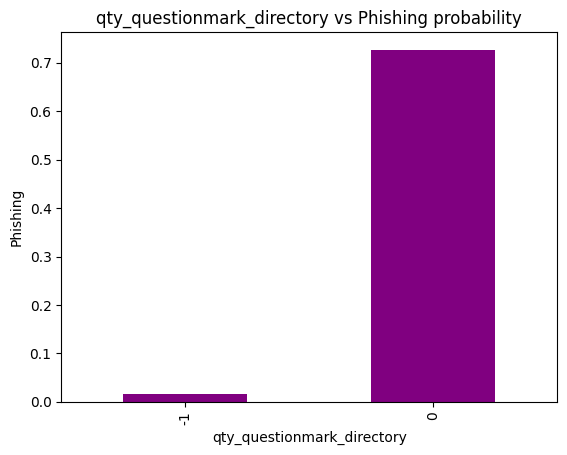

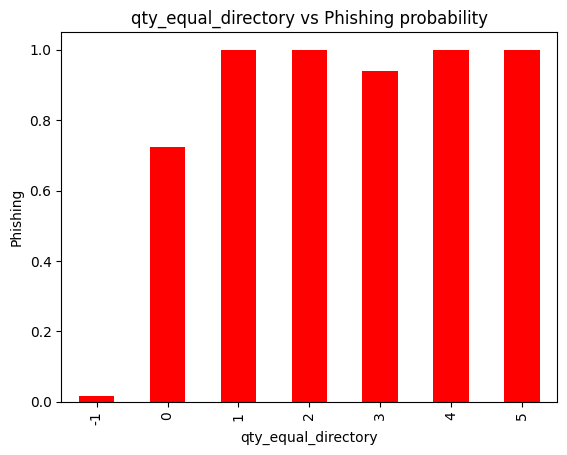

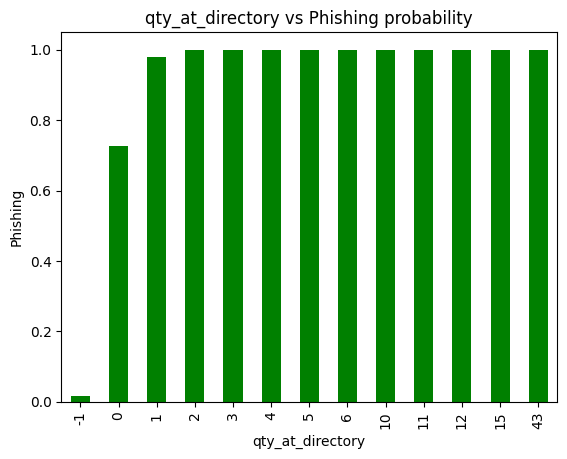

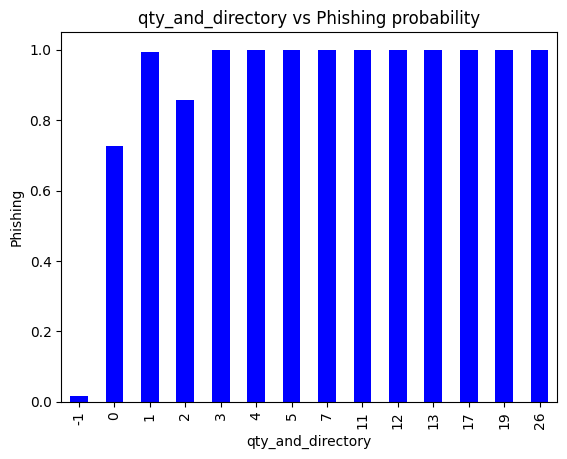

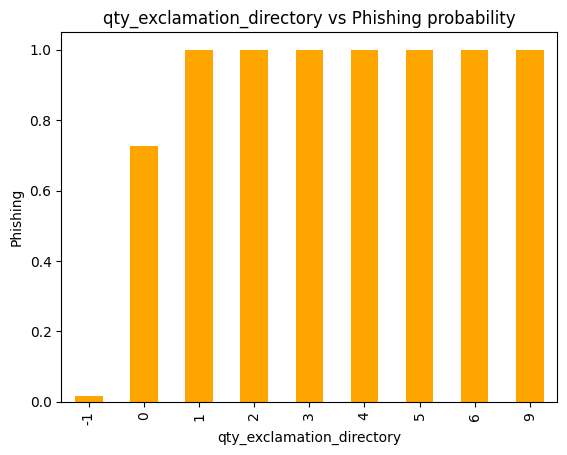

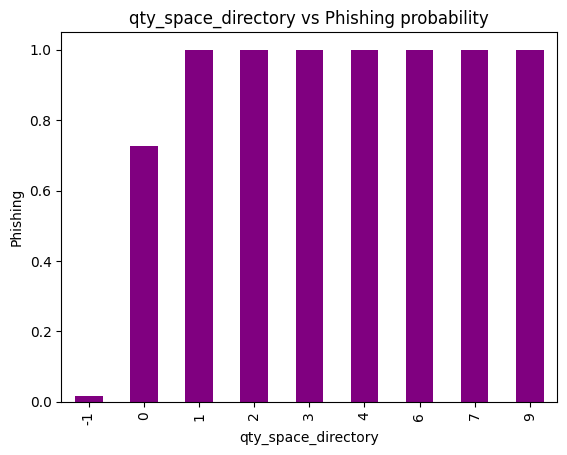

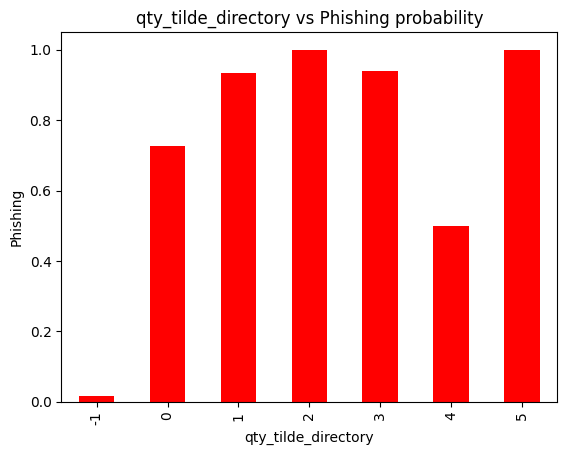

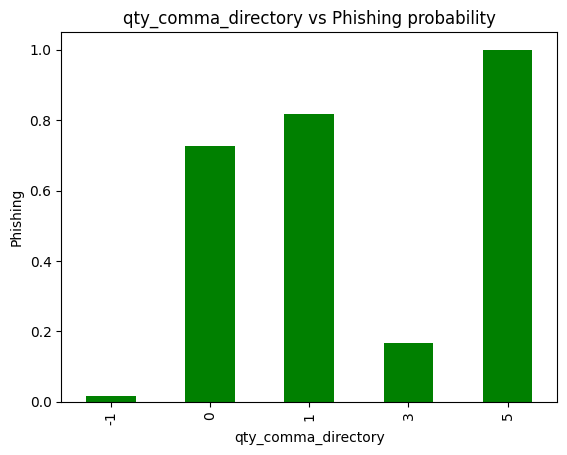

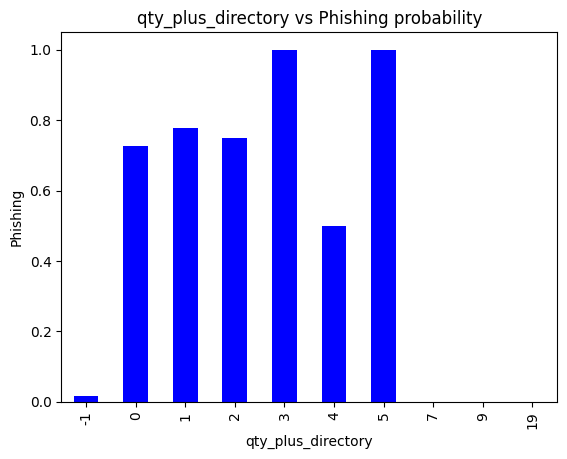

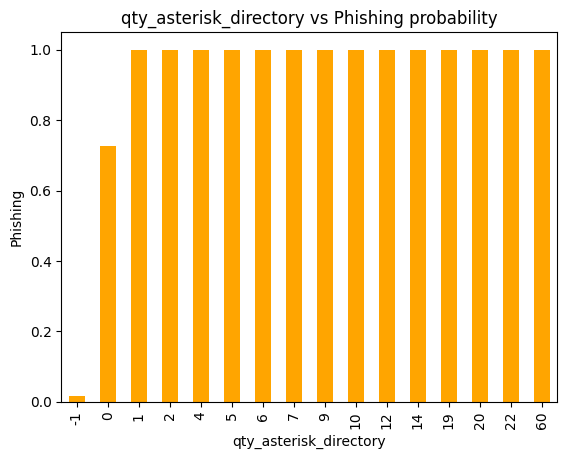

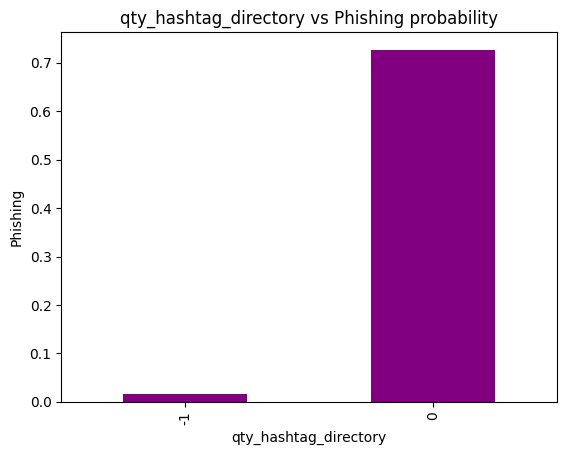

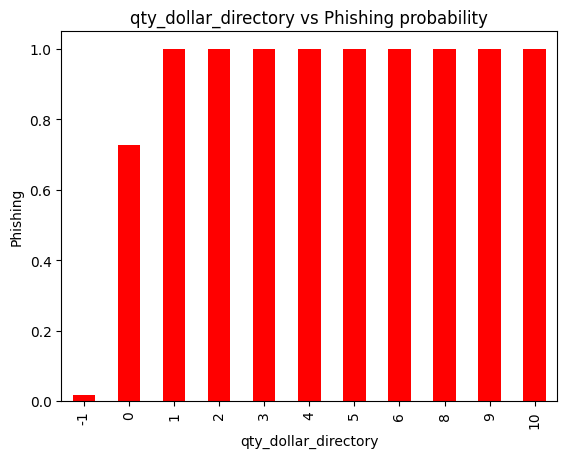

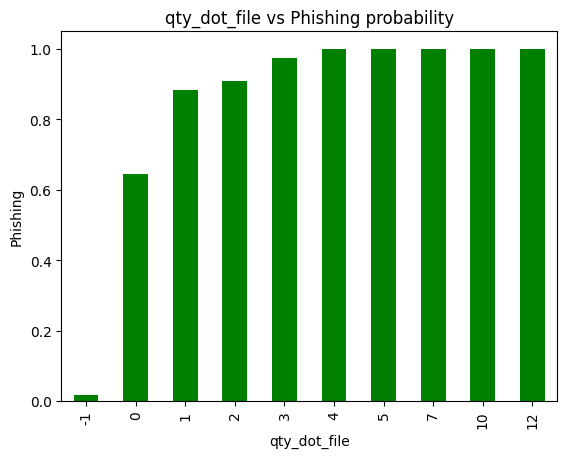

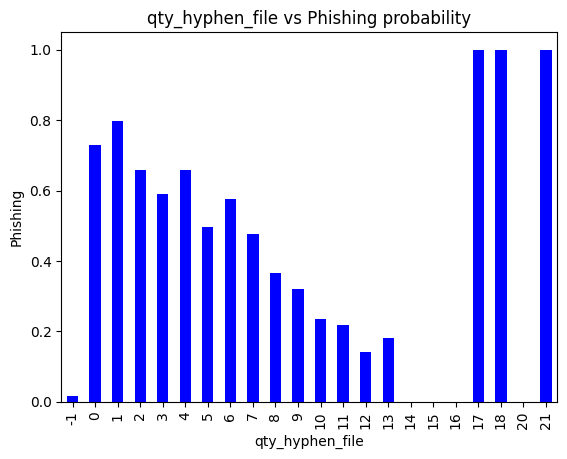

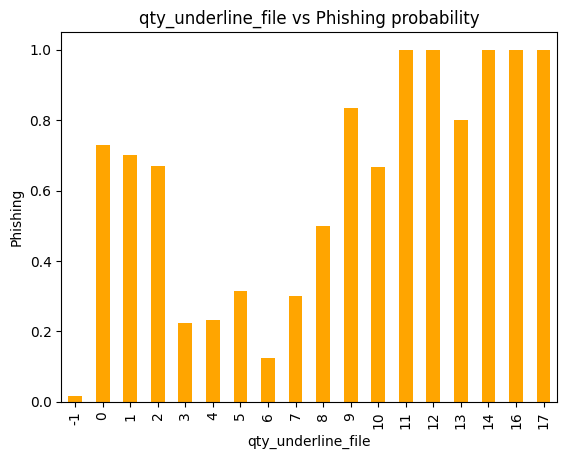

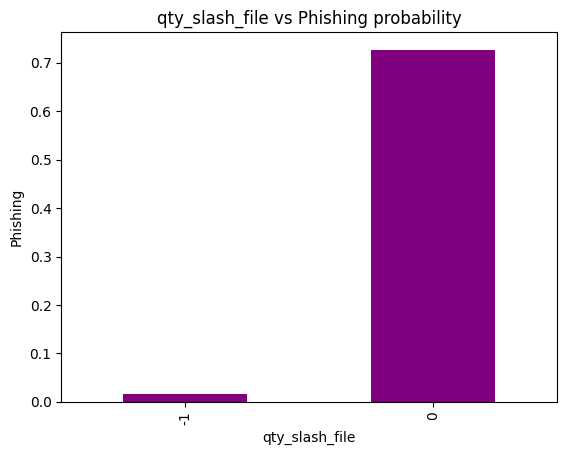

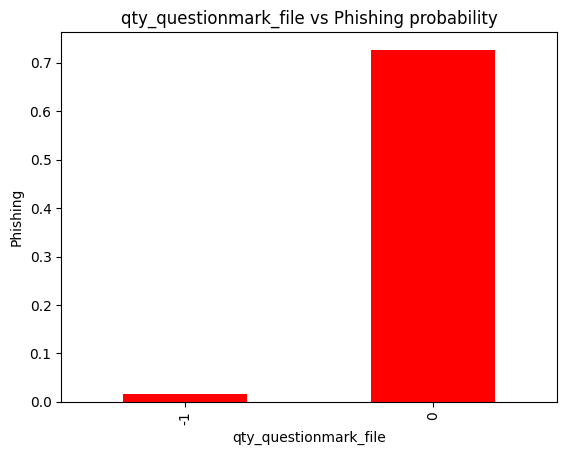

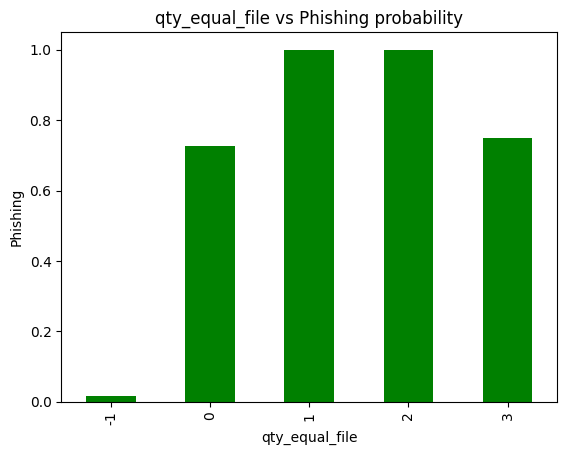

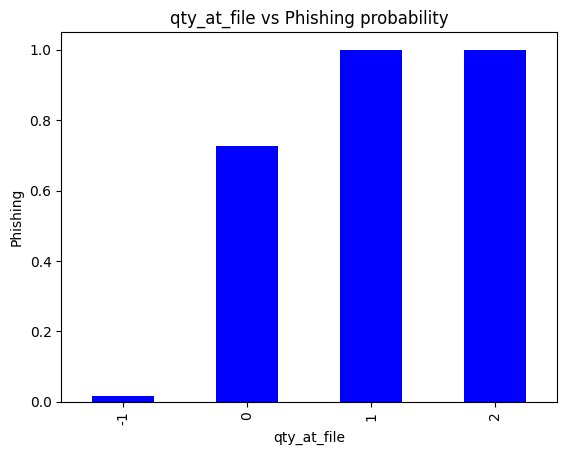

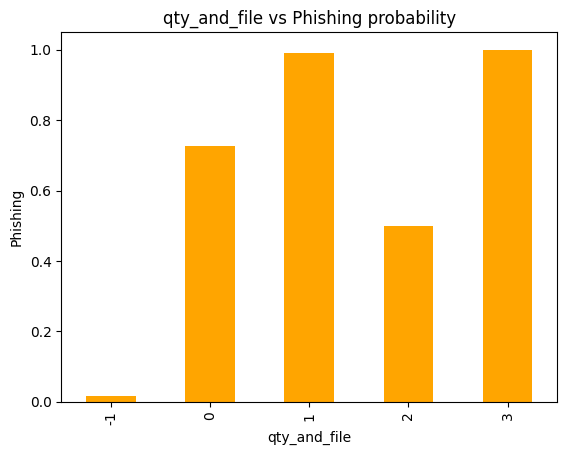

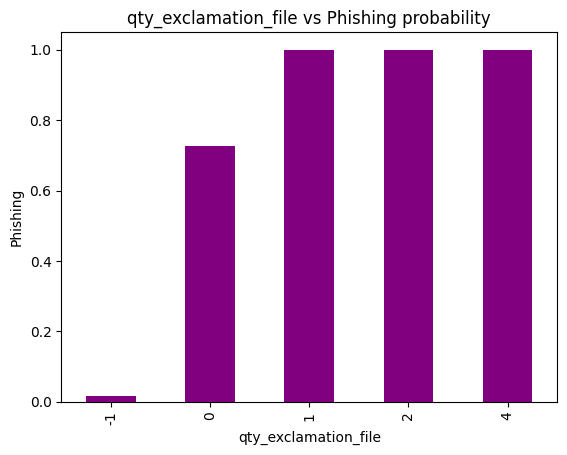

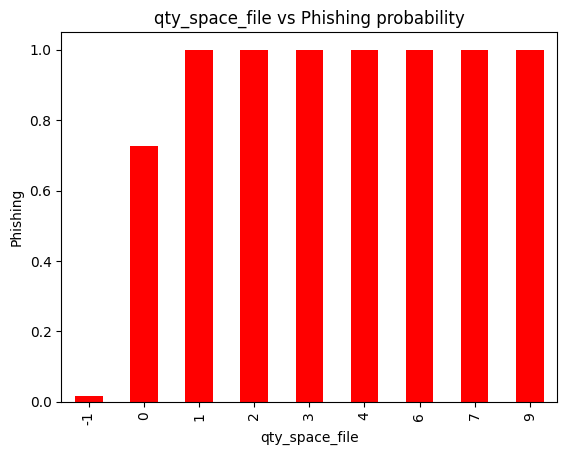

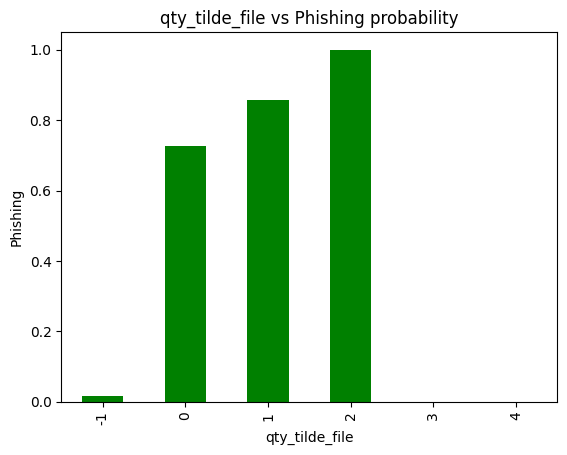

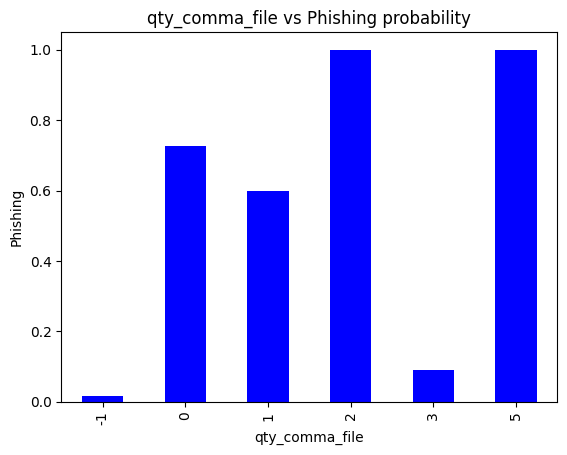

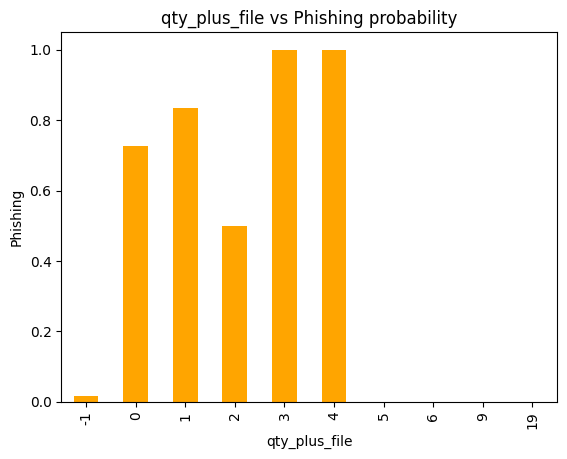

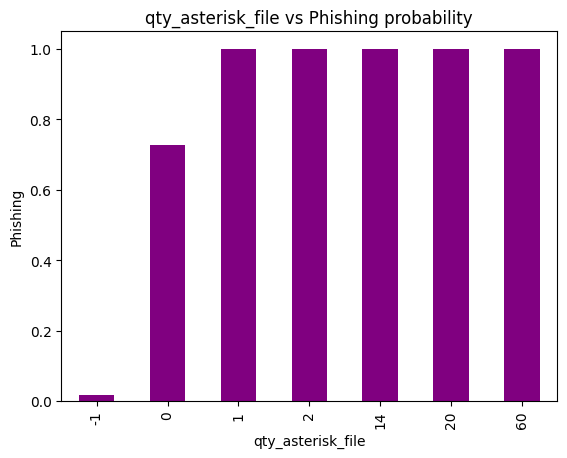

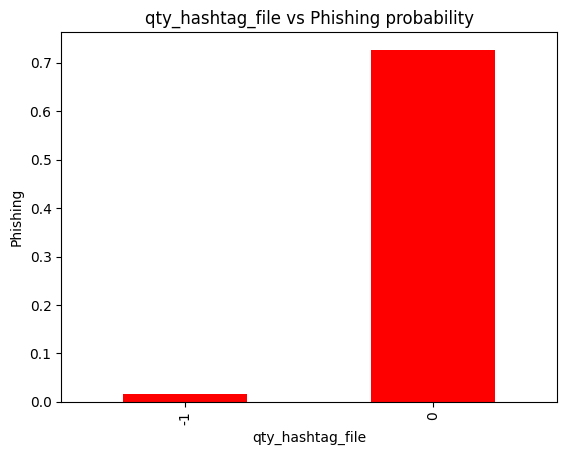

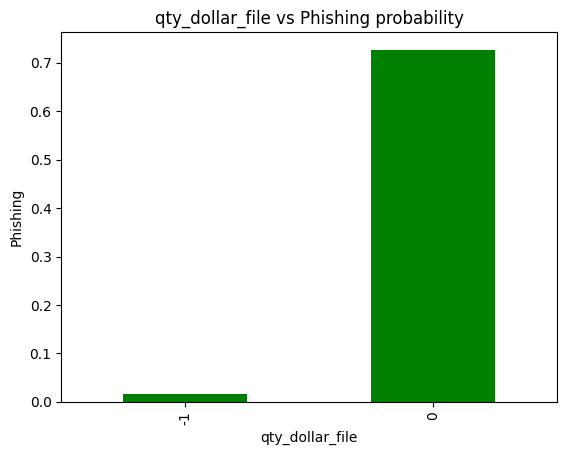

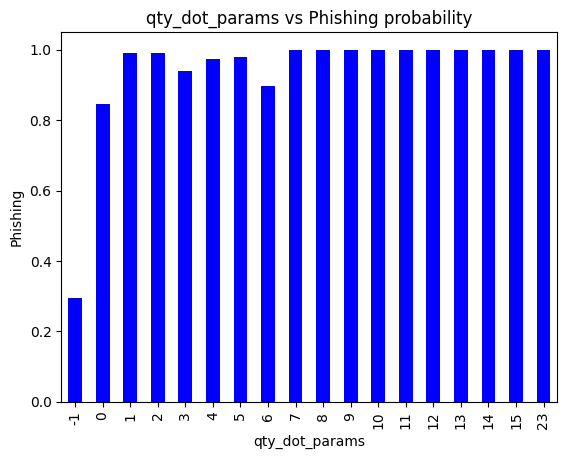

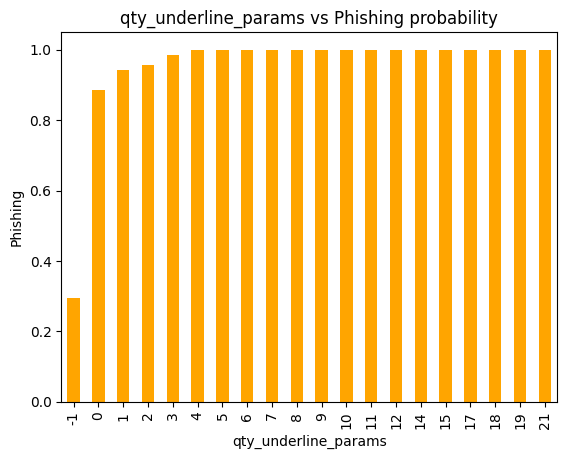

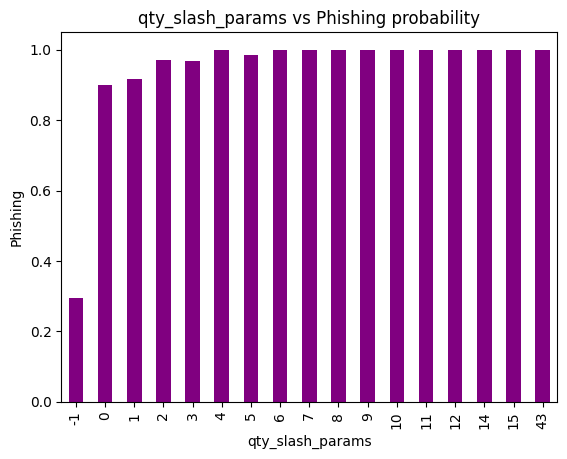

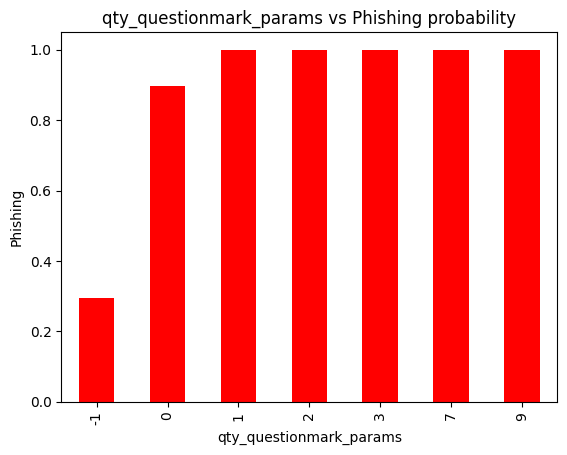

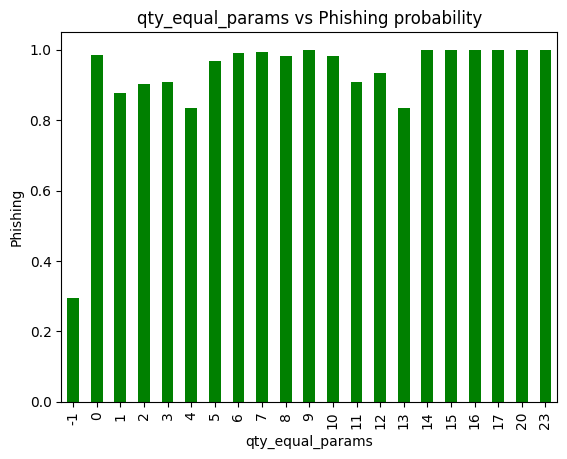

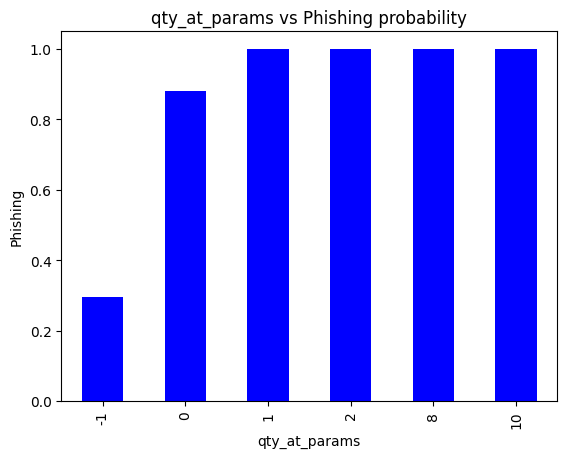

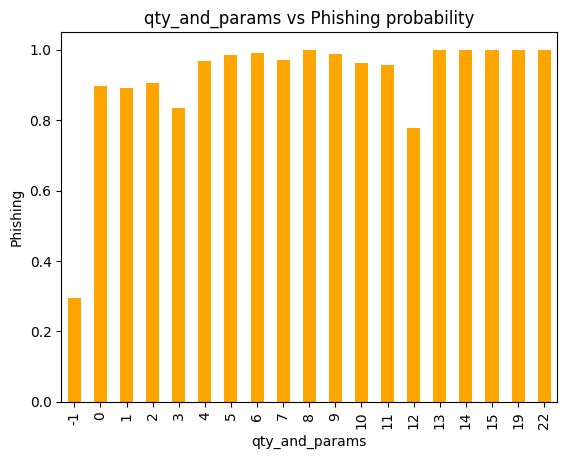

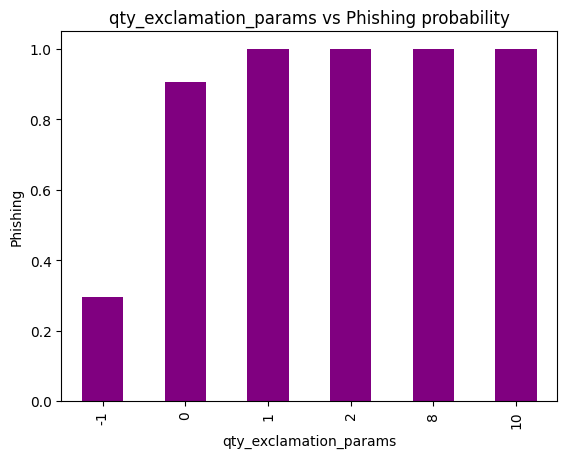

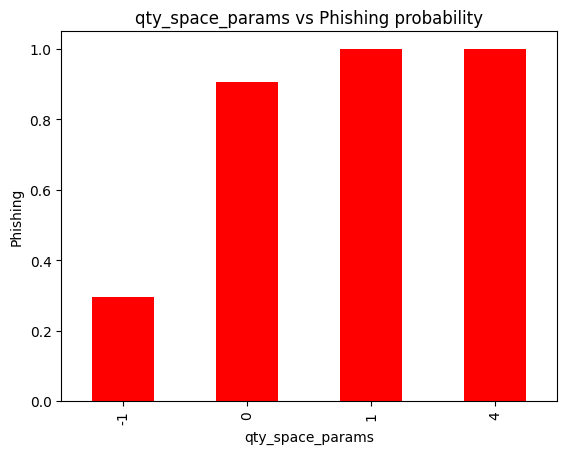

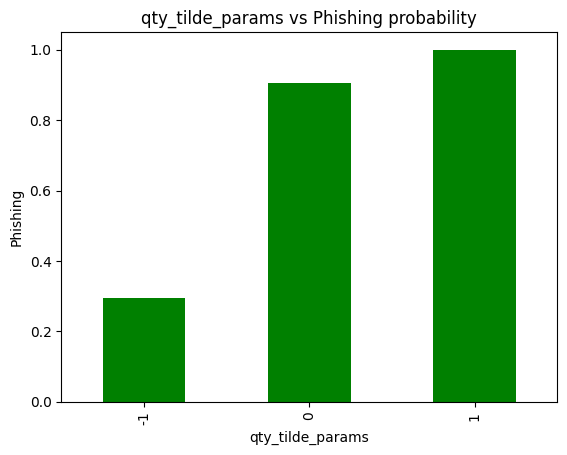

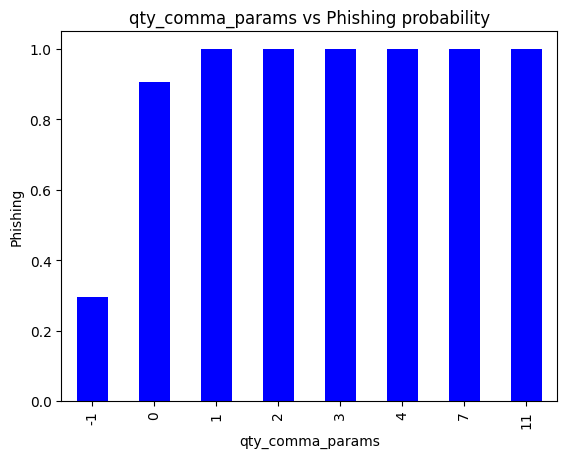

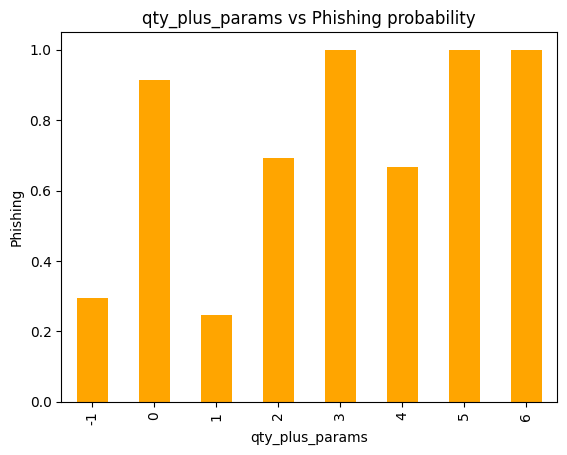

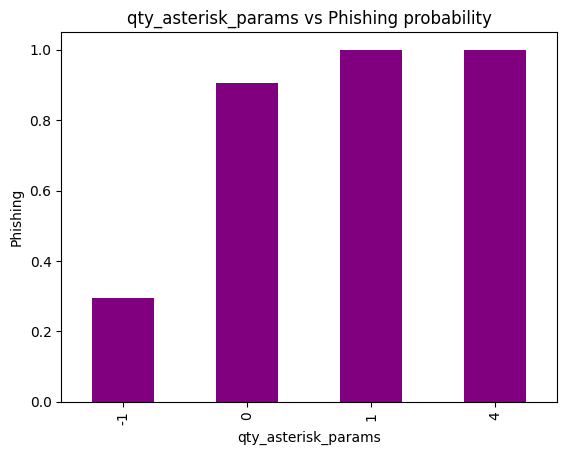

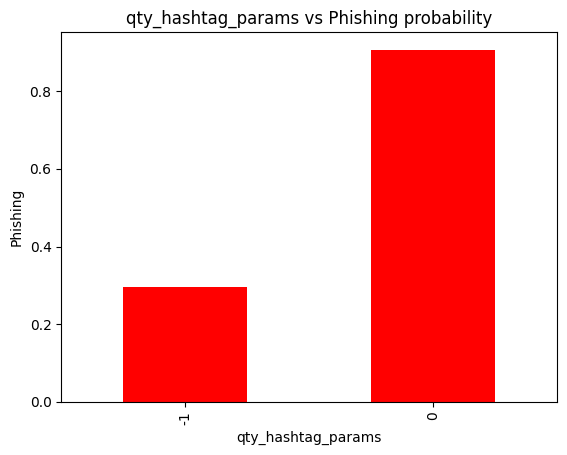

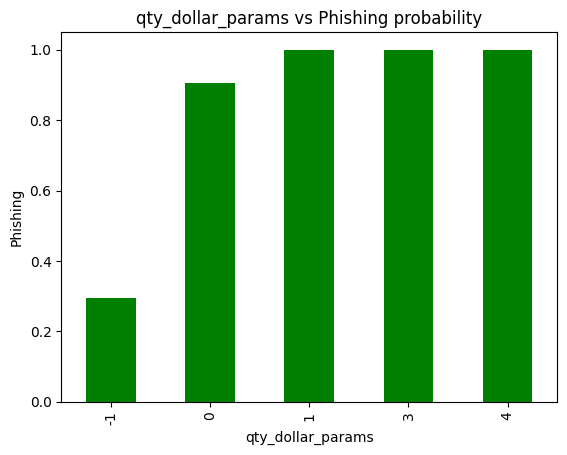

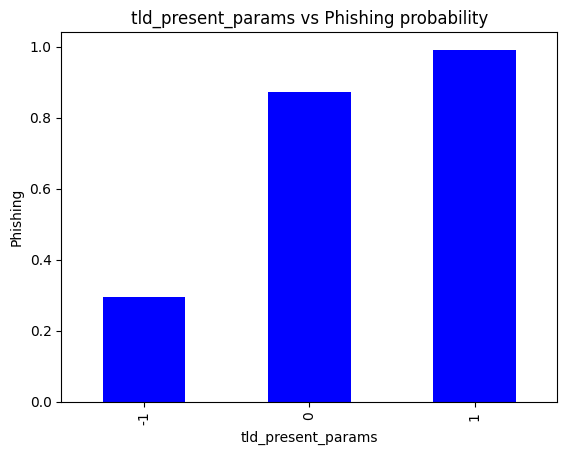

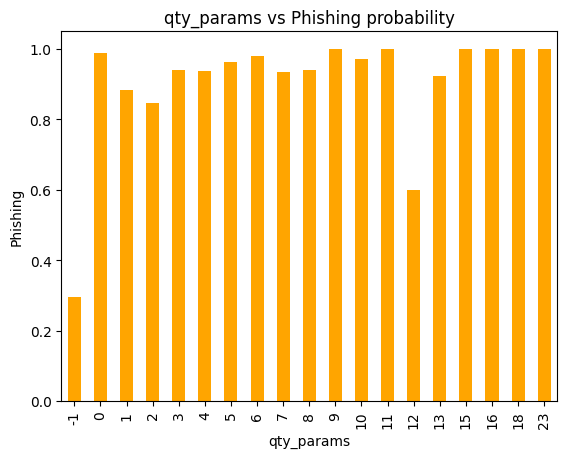

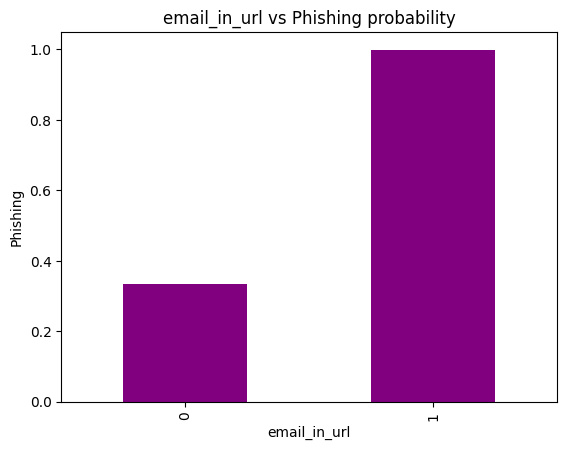

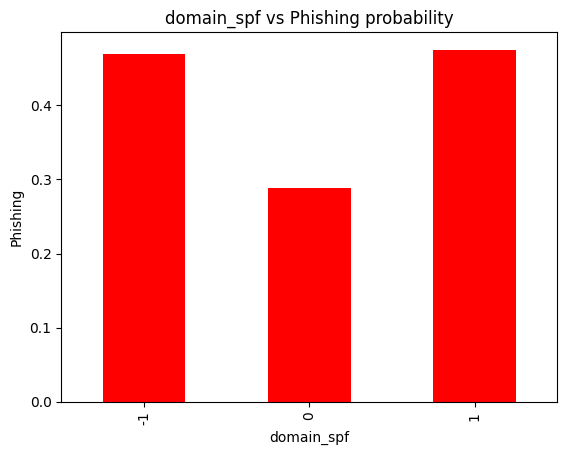

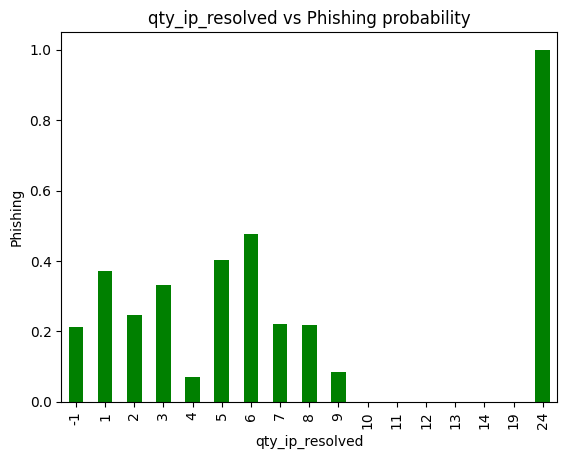

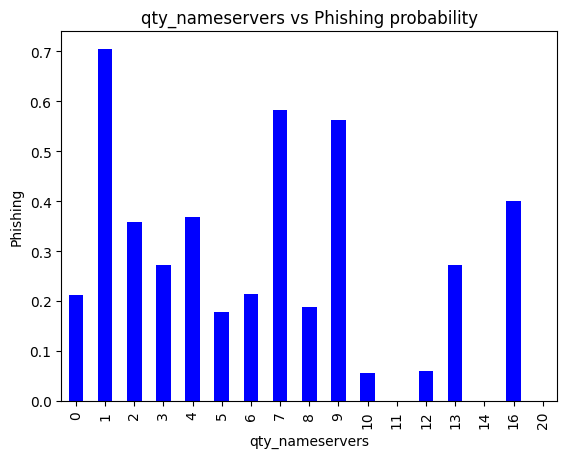

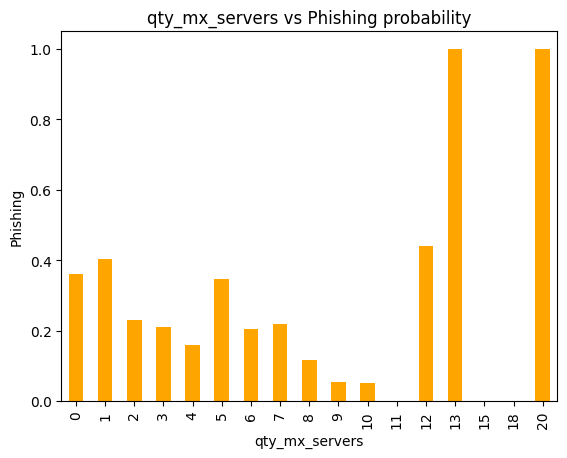

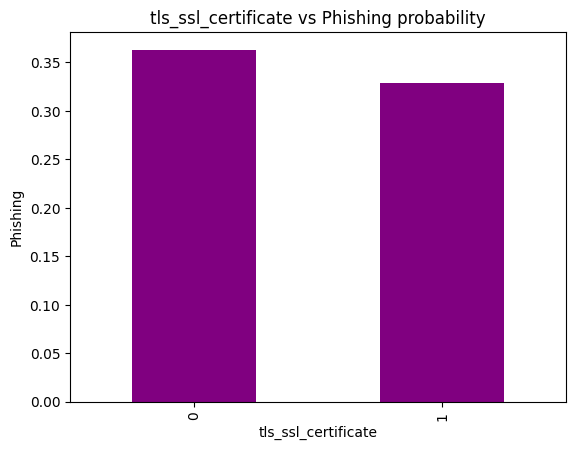

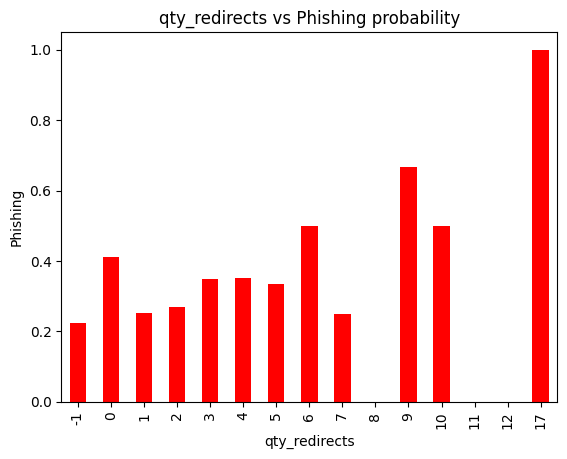

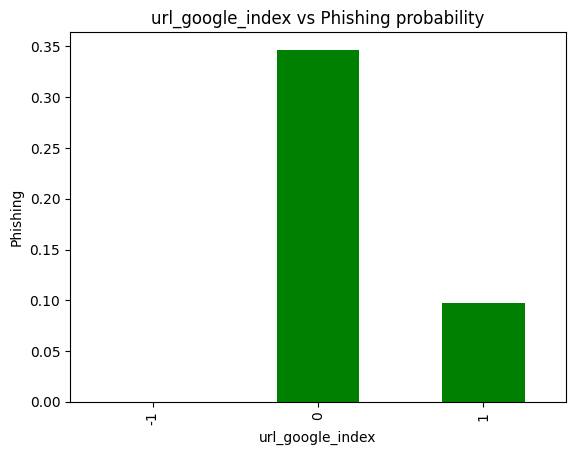

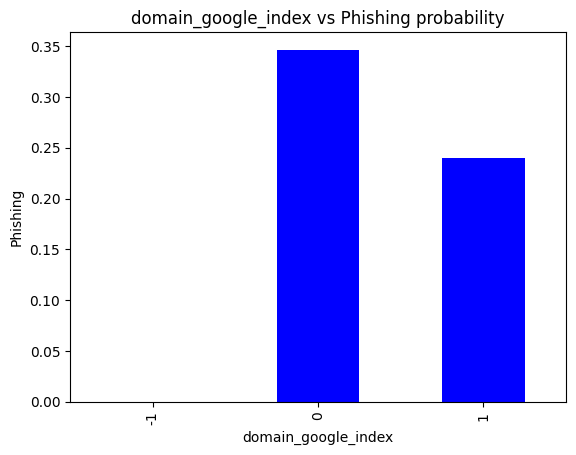

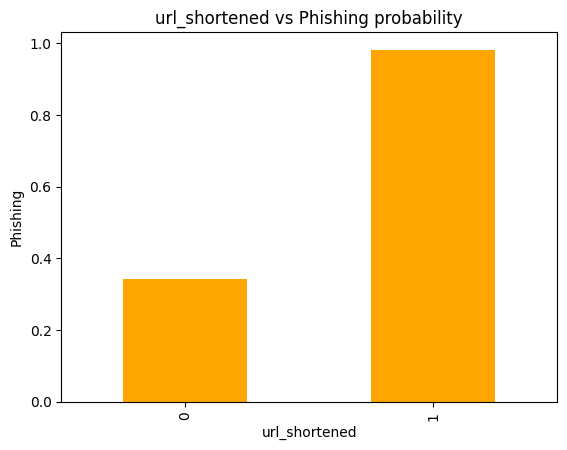

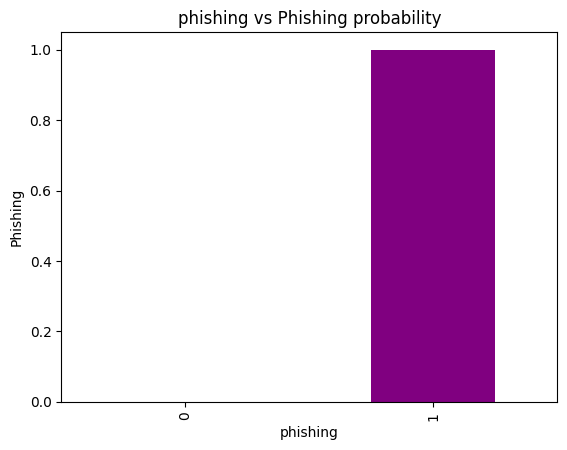

In [15]:
data = df.copy()
# Define a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple']

for i, feature in enumerate(discrete_features):
    # Generate the bar plot with a specific color
    data.groupby(feature)['phishing'].mean().plot.bar(color=colors[i % len(colors)])
    plt.xlabel(feature)
    plt.ylabel('Phishing')
    plt.title(f"{feature} vs Phishing probability")
    plt.show()

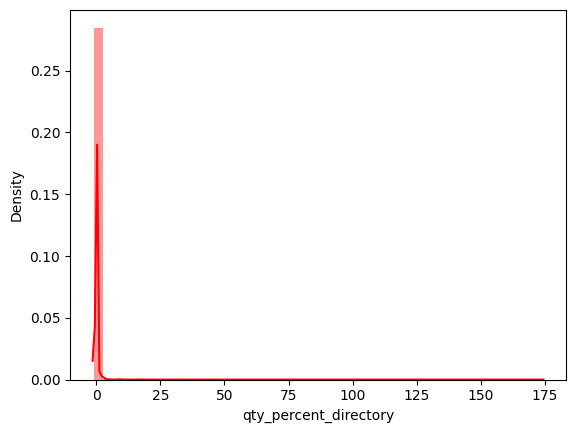

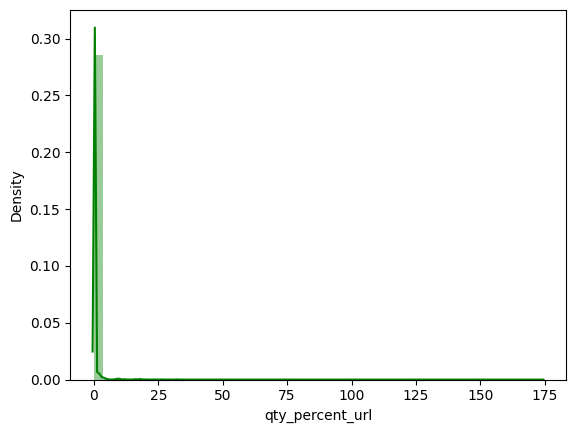

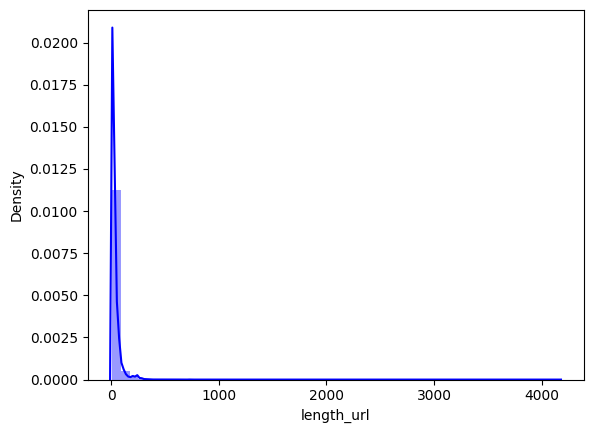

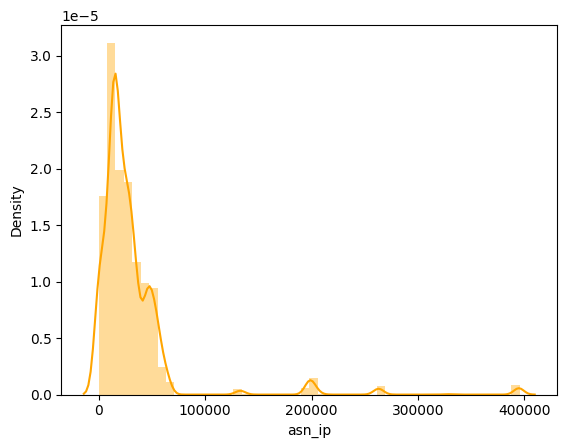

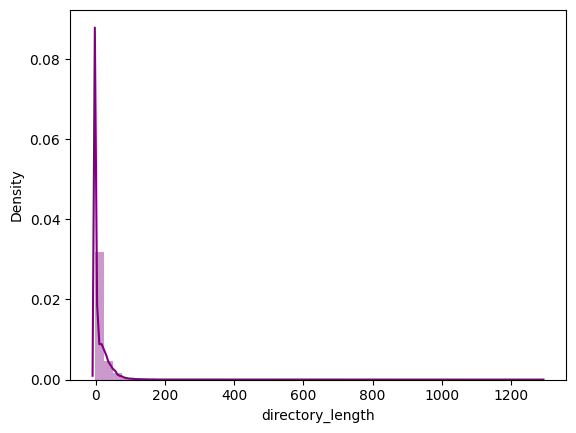

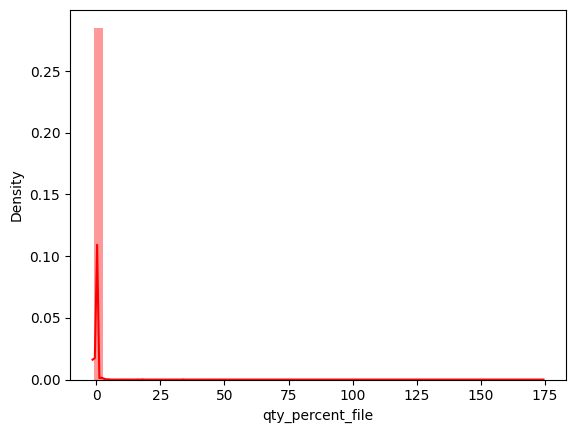

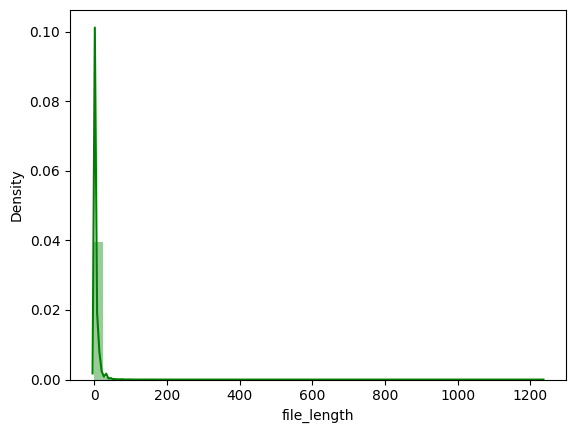

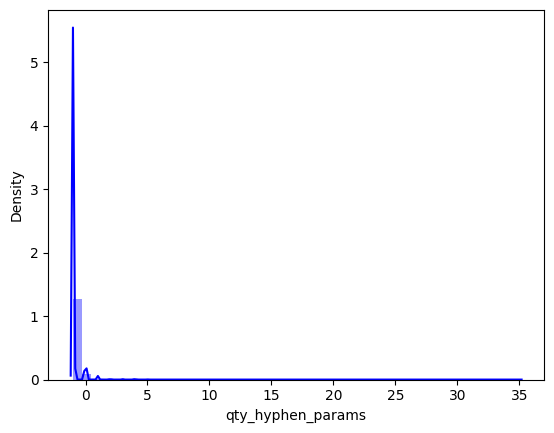

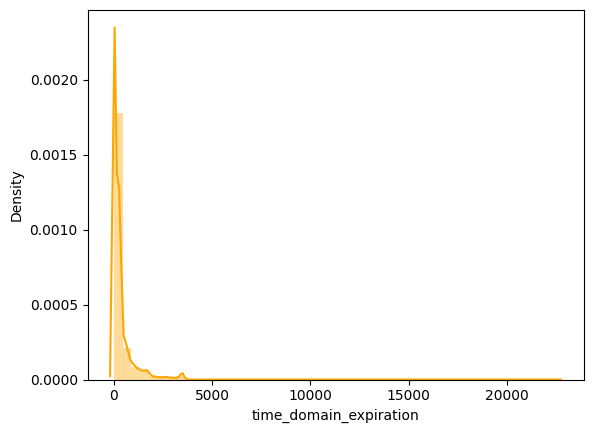

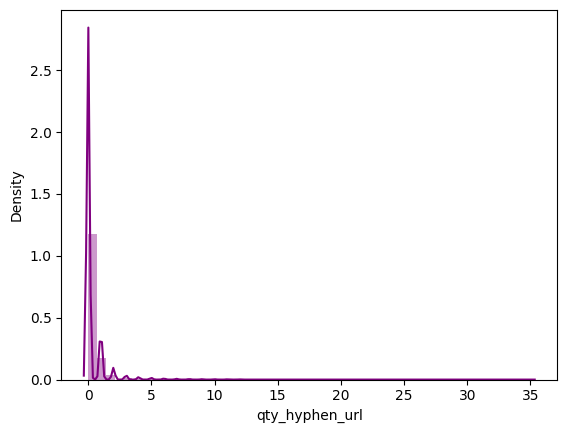

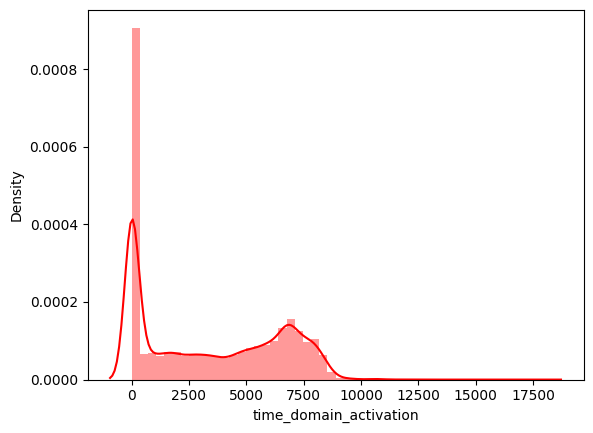

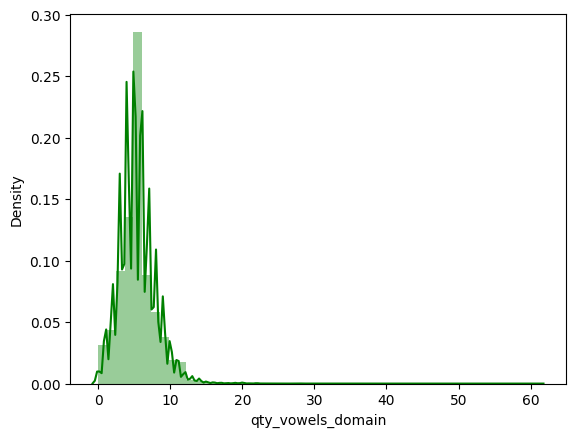

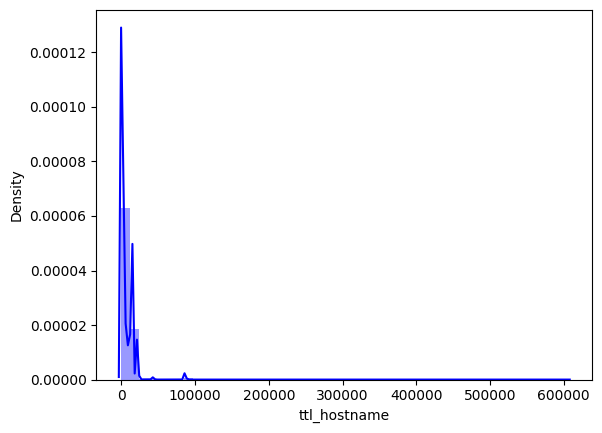

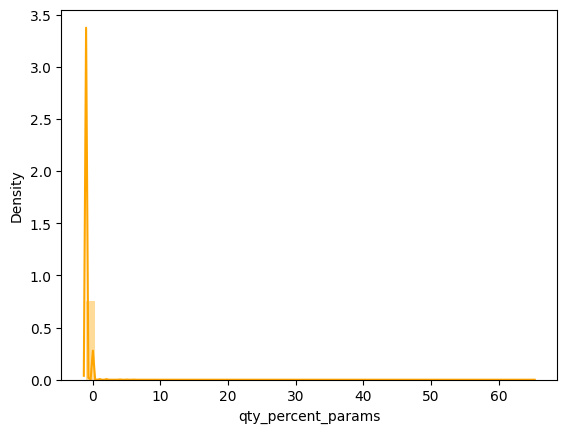

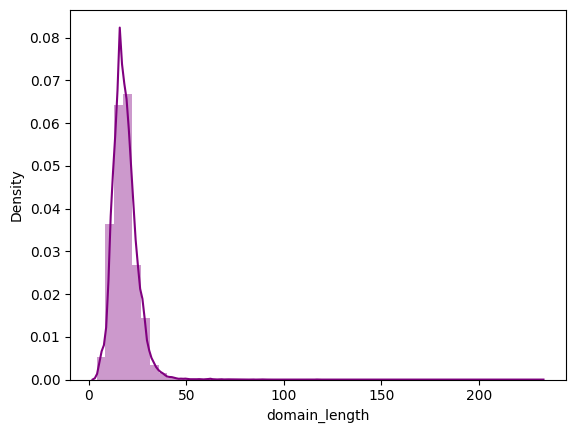

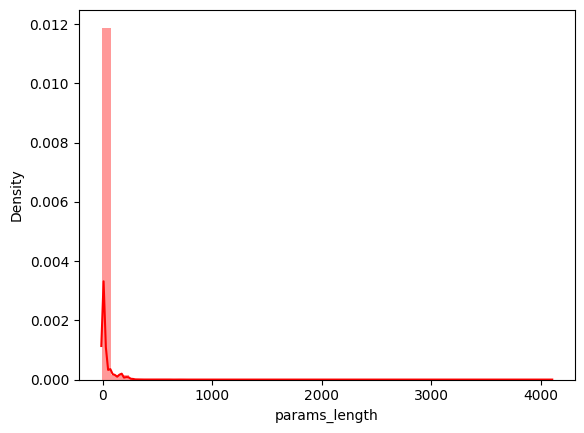

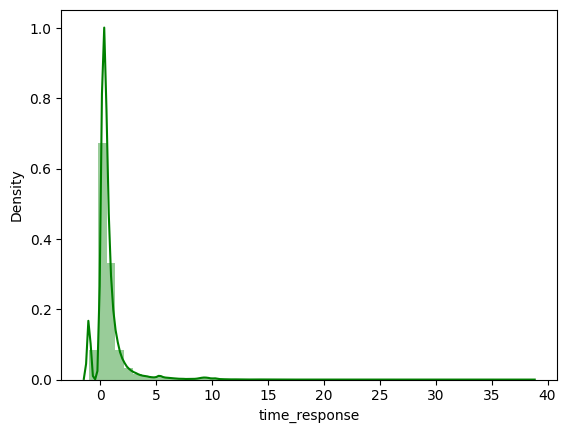

In [16]:
data = df.copy()
# Define a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple']
i=0
for feature in continuous_features:
    sns.distplot(data[feature],color=colors[i%len(colors)])
    plt.show()
    i+=1

# BoxCox Transformation (as obtained in the previous EDA)

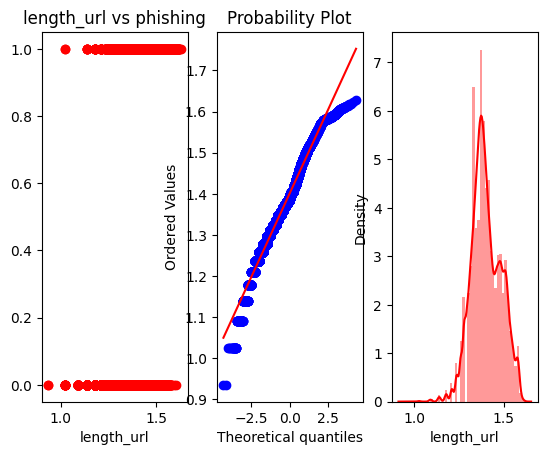

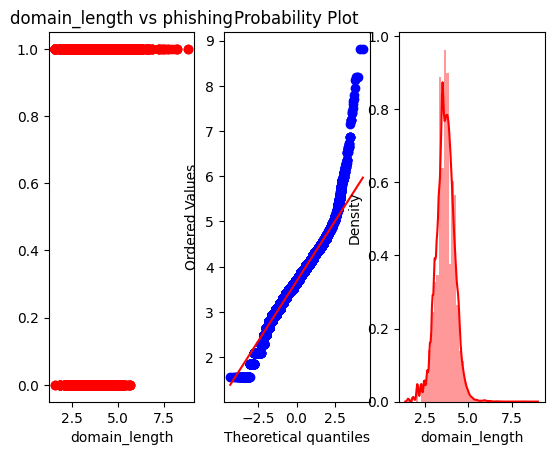

In [17]:
data = df.copy()

# Define a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple']
i=0
n=len(colors)

for feature in continuous_features:
    if 0 in data[feature].unique():
        pass
    else:
        try:
            data[feature], parameters =  stat.boxcox(df[feature])
        except:
            continue
        plt.subplot(1,3,1)
        plt.scatter(data[feature],data['phishing'],color=colors[i%len(colors)])
        plt.xlabel(feature)

        plt.title(f"{feature} vs phishing")
        plt.subplot(1,3,2)
        stat.probplot(data[feature],dist='norm',plot=pylab)

        plt.subplot(1,3,3)
        sns.distplot(data[feature],color=colors[i%len(colors)])

        plt.show()

# Categorical Features

No categorical features present

# Outliers

In [18]:
# Define a function to remove outliers based on Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    return df[(z_scores < threshold).all(axis=1)]

# Specify the columns to check for outliers
columns_to_check = list(df.columns)

# Remove outliers from the dataframe
df_no_outliers = remove_outliers_zscore(df, columns_to_check)

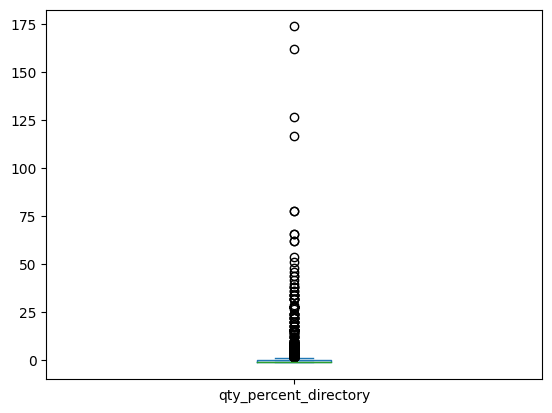

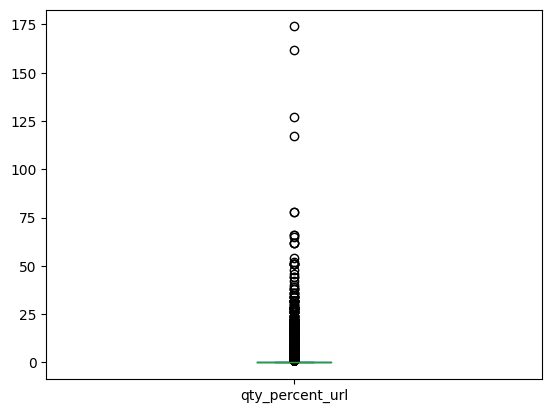

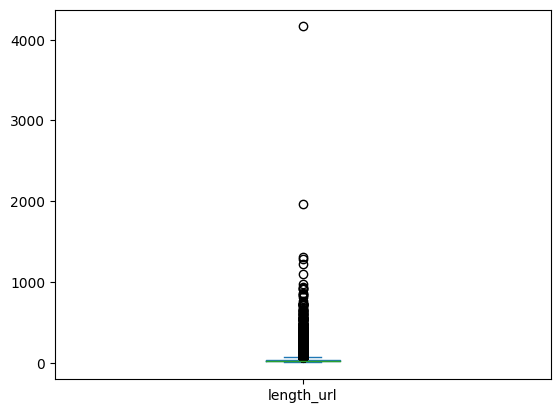

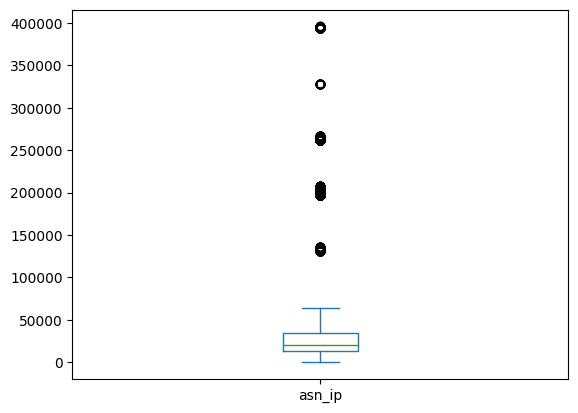

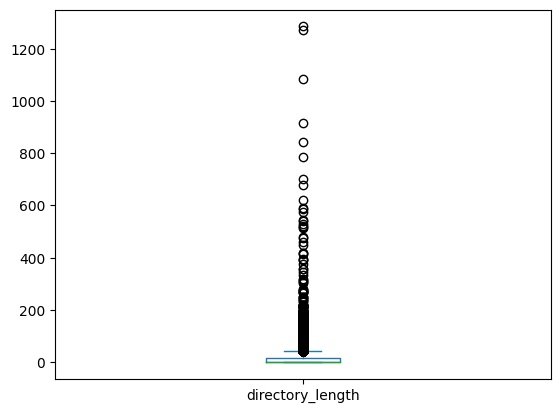

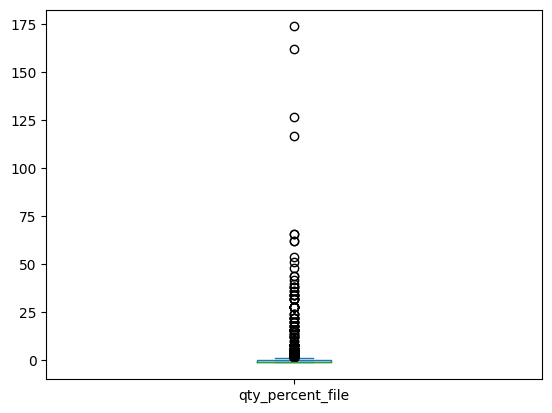

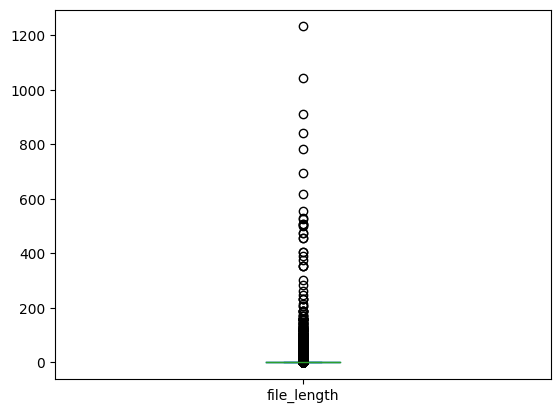

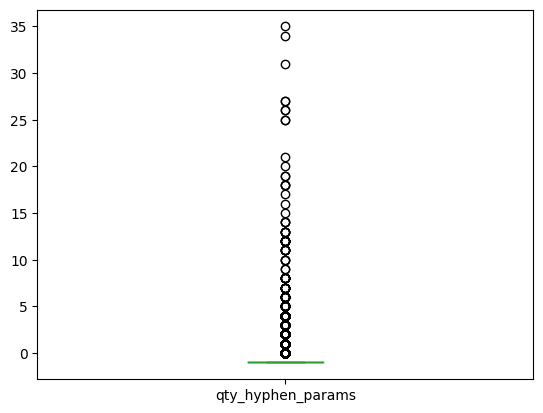

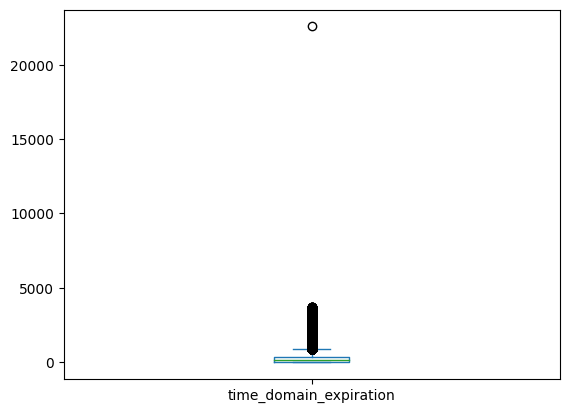

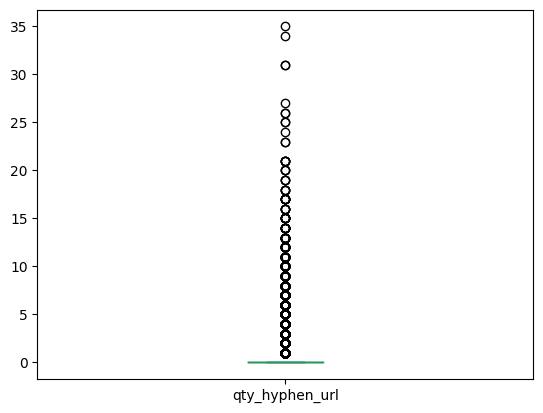

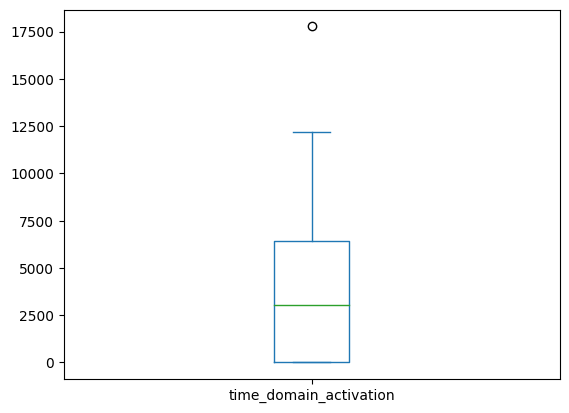

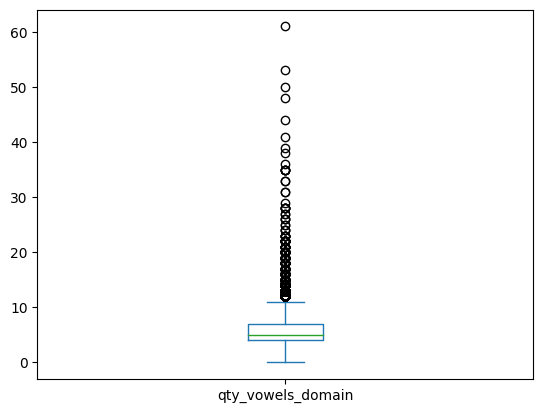

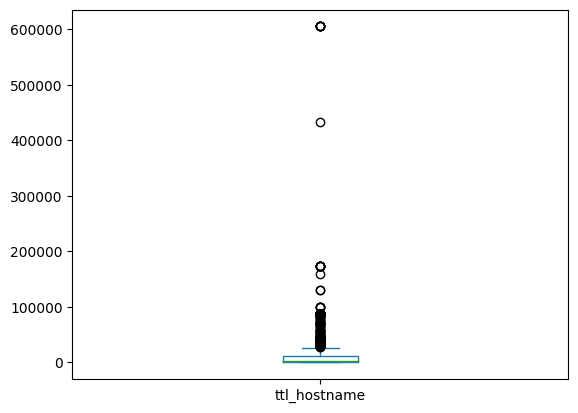

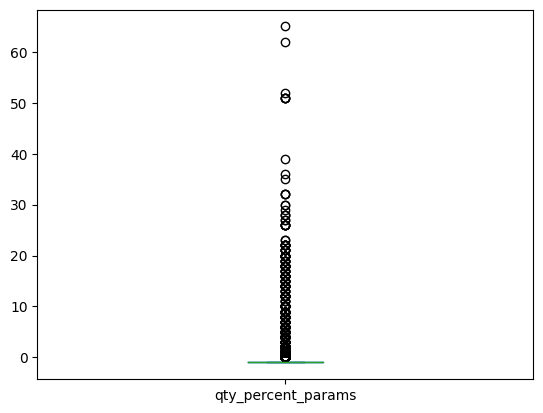

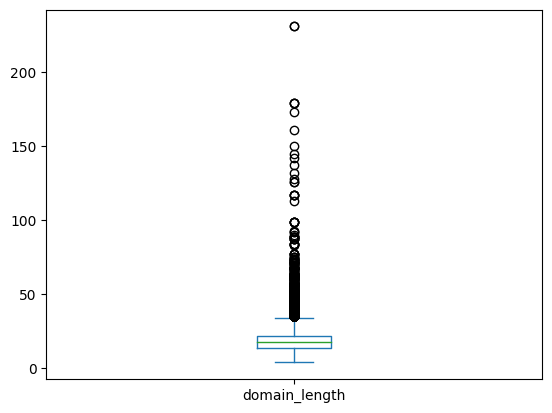

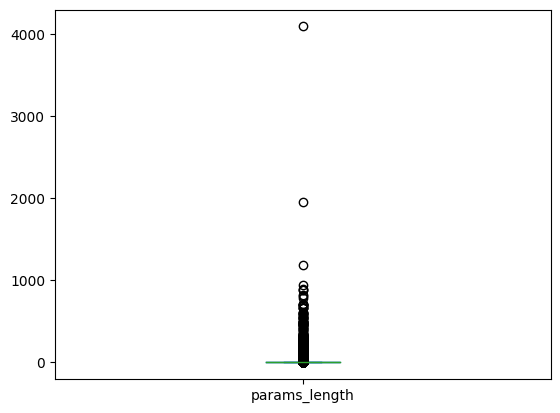

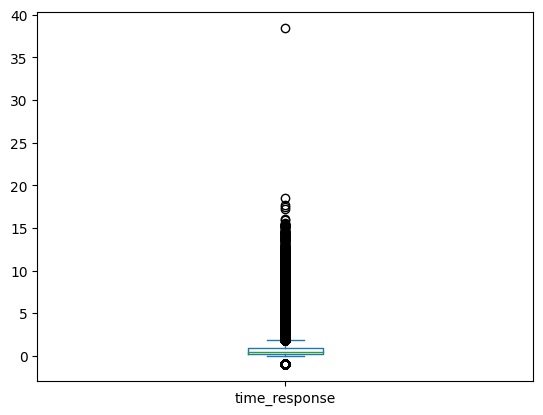

In [19]:
data = df.copy()
for feature in continuous_features:
    data[feature].plot.box()
    plt.show()

# Corelations

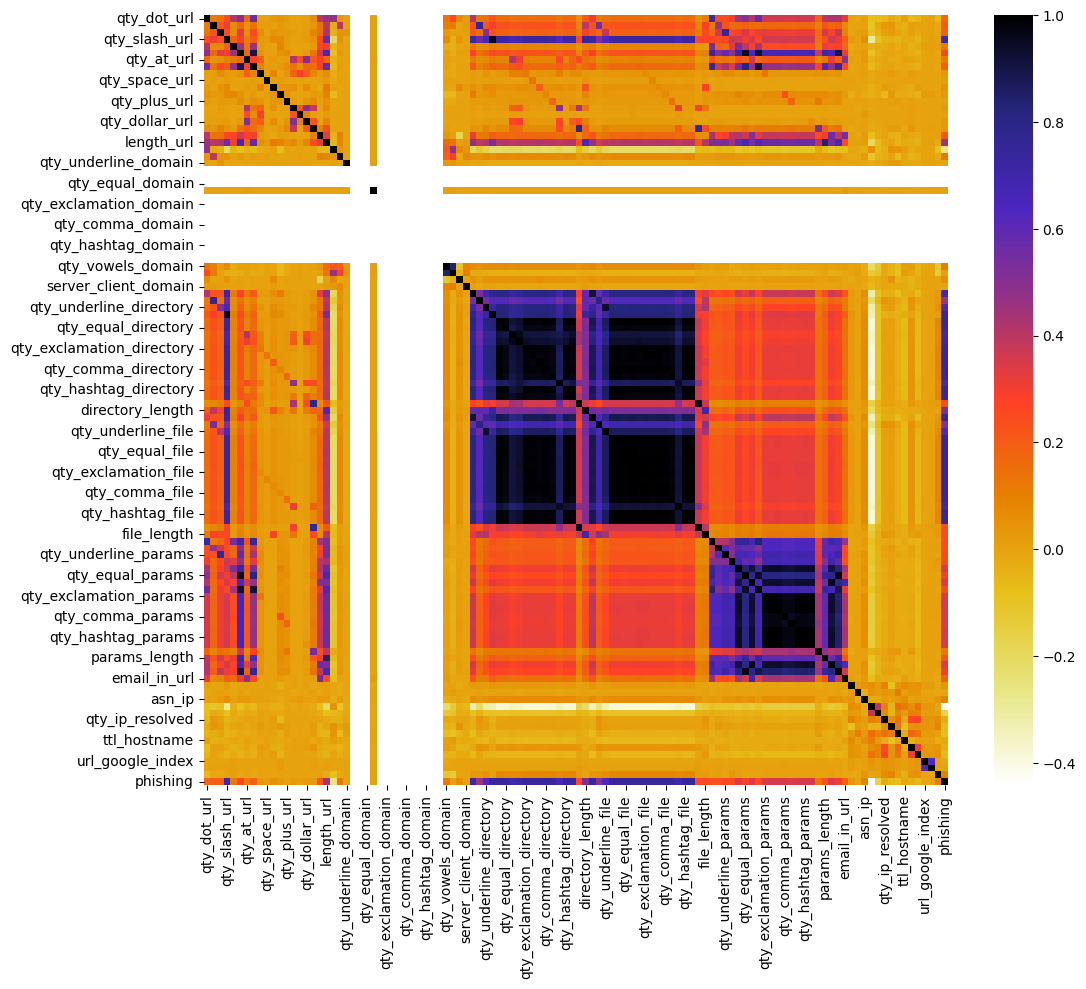

In [20]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.CMRmap_r)
plt.show()

In [21]:
np.corrcoef(df['phishing'],df['time_domain_activation'])

array([[ 1.        , -0.44187497],
       [-0.44187497,  1.        ]])

In [22]:
np.corrcoef(df['phishing'],np.sqrt(df['time_domain_activation']))

array([[ 1., nan],
       [nan, nan]])

In [23]:
df['phishing'].value_counts(normalize=True)

0    0.65428
1    0.34572
Name: phishing, dtype: float64

In [24]:
df['phishing'].value_counts()

0    58000
1    30647
Name: phishing, dtype: int64

# multicolinearity removal

In [25]:
# Calculate correlation matrix
corr_matrix = df.corr()

def get_high_correlation_feature(dataset, threshold):
    # Find highly correlated feature pairs
    high_corr_features = set()
    for i in range(len(corr_matrix.columns)-1):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                feature_i = corr_matrix.columns[i]
                feature_j = corr_matrix.columns[j]
                high_corr_features.add(feature_i)
    return high_corr_features

high_corr_features=get_high_correlation_feature(df.iloc[:-1],0.85)

# Remove highly correlated features
for feature in df.columns[:-1]:
  if feature in high_corr_features:
     df.drop(feature, axis=1, inplace=True)

# Print the DataFrame after removing highly correlated features
print(len(high_corr_features))
print(len(df.columns))

42
70


# top k correlated features (indpendent and dependent variable)

In [26]:
def get_top_correlated_features(df, dependent_feature, k):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Get the absolute correlation values with the dependent feature
    corr_with_dependent = corr_matrix[dependent_feature].abs()

    # Sort the correlation values in descending order
    sorted_corr = corr_with_dependent.sort_values(ascending=False)

    # Exclude the dependent feature itself
    sorted_corr = sorted_corr.drop(dependent_feature)

    # Get the top k features
    top_k_features = sorted_corr[:k].index.tolist()

    return top_k_features

dependent_feature = 'phishing'  # Replace 'dependent_feature' with the name of the dependent feature
k = 25 # k number of top correlated features

top_features = get_top_correlated_features(df, dependent_feature, k)
print(top_features)
print(len(top_features))

['qty_questionmark_directory', 'qty_slash_url', 'qty_dot_directory', 'qty_underline_directory', 'directory_length', 'qty_hyphen_file', 'length_url', 'qty_hyphen_directory', 'time_domain_activation', 'qty_questionmark_params', 'qty_equal_url', 'qty_dot_domain', 'qty_underline_params', 'file_length', 'qty_percent_directory', 'qty_slash_params', 'qty_dot_params', 'qty_hyphen_params', 'params_length', 'qty_tld_url', 'qty_hyphen_url', 'qty_underline_url', 'email_in_url', 'qty_dot_url', 'time_domain_expiration']
25


In [27]:
for col in df.columns[:-1]:
  if col not in top_features:
    df.drop(col, axis=1, inplace=True)

In [28]:
len(df.columns)

26

In [29]:
# remove_feat=[]
# tmp=pd.read_csv("dataset_full.csv")
# for i in tmp.columns:
#   if i not in df:
#     remove_feat.append(i)
# remove_feat

In [30]:
df['phishing'].value_counts()

0    58000
1    30647
Name: phishing, dtype: int64

# the 'phishing'/output feature is highly imbalanced, so we might need to apply stratified split of data

# Scaling and Model Training

In [31]:
df.iloc[6:7,69: ]

""
6


In [32]:
from sklearn.model_selection import train_test_split

X=df.iloc[:,:-1]
y=df.iloc[:,-1]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

1. **Logistic Regression:** A simple and widely used algorithm that models the probability of the input belonging to different classes using a logistic function.

2. **Decision Trees:** Builds a tree-like model by partitioning the feature space based on a sequence of decision rules.

3. **Random Forest:** An ensemble learning method that combines multiple decision trees to make predictions by averaging the outputs of individual trees.

4. **Naive Bayes:** Based on Bayes' theorem, this algorithm assumes independence between features and calculates the probability of a class given the input features.

5. **Support Vector Machines (SVM):** A powerful algorithm that separates data points using hyperplanes to find an optimal decision boundary.

6. **K-Nearest Neighbors (KNN)**: Assigns labels to input based on the majority vote of its k nearest neighbors in the feature space.

7. **Gradient Boosting Methods**: Algorithms such as XGBoost and LightGBM that combine weak learners (usually decision trees) in an additive manner to create a strong learner.

8. **Neural Networks**: Deep learning algorithms that consist of multiple layers of interconnected artificial neurons to model complex relationships in the data.

9. **AdaBoost**: An ensemble method that combines multiple weak learners to create a strong learner by giving more weight to misclassified samples.

10. **Linear Discriminant Analysis (LDA)**: A dimensionality reduction technique that finds linear combinations of features to maximize class separability.

11. **Quadratic Discriminant Analysis (QDA)**: Similar to LDA, but allows for quadratic decision boundaries instead of linear ones.

12. **Gaussian Process**: A probabilistic algorithm that models data as a distribution of functions, allowing for uncertainty estimation in predictions.

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

# Define the scaling techniques to compare
scalers = {
    'Standardization': StandardScaler(),
    'Min-Max Scaling': MinMaxScaler(),
    'Robust Scaling': RobustScaler()
}

# Define the classifier for evaluation
classifier = LogisticRegression()

# Evaluate each scaling technique using cross-validation
results = {}
for scaler_name, scaler in scalers.items():
    # Create a pipeline with the scaler and classifier
    pipeline = Pipeline([
        ('scaler', scaler),
        ('classifier', classifier)
    ])

    # Perform cross-validation with the pipeline
    scores = cross_val_score(pipeline, X, y, cv=5)  # Adjust cv parameter as needed

    # Store the average score
    results[scaler_name] = scores.mean()

# Find the best scaling technique based on the average scores
best_scaler = max(results, key=results.get)
best_score = results[best_scaler]

print("Scaling Technique Scores:")
for scaler_name, score in results.items():
    print(f"{scaler_name}: {score}")

print(f"\nBest Scaling Technique: {best_scaler}")
print(f"Best Score: {best_score}")

Scaling Technique Scores:
Standardization: 0.9206515465641341
Min-Max Scaling: 0.9163423151154229
Robust Scaling: 0.92068538560289

Best Scaling Technique: Robust Scaling
Best Score: 0.92068538560289


In [34]:
# apply standardization scaling on data
from sklearn.preprocessing import StandardScaler

# Create the StandardScaler object
scaler = StandardScaler()

# Apply standardization scaling to the training set
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaling to the test set
X_test_scaled = scaler.transform(X_test)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [36]:
models={
    'LogisticRegression':LogisticRegression(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'SVC':SVC(),
    'AdaBoostClassifier':AdaBoostClassifier()
}

In [37]:
def evaluate_model(X_train,y_train,X_test,y_test,models):
        report = {}
        for i in range(len(models)):
            model = list(models.values())[i]
            # Train model
            model.fit(X_train,y_train)

            # Predict Testing data
            y_test_pred =model.predict(X_test)

            # Get scores for train and test data
            test_model_score = accuracy_score(y_test,y_test_pred)

            report[list(models.keys())[i]] = {
                "accuracy": test_model_score,
                "precision": precision_score(y_test, y_test_pred),
                "recall": recall_score(y_test, y_test_pred),
                "f1_score": f1_score(y_test, y_test_pred),
            }

        return report

In [38]:
model_report:dict=evaluate_model(X_train,y_train,X_test,y_test,models)

In [39]:
for key, value in model_report.items():
    print(f"{key}: {value}")

LogisticRegression: {'accuracy': 0.9121827411167512, 'precision': 0.8677818883705968, 'recall': 0.8800978792822186, 'f1_score': 0.873896493075241}
DecisionTreeClassifier: {'accuracy': 0.9429216018048505, 'precision': 0.926073926073926, 'recall': 0.9073409461663948, 'f1_score': 0.9166117336849045}
RandomForestClassifier: {'accuracy': 0.9536379018612521, 'precision': 0.9297279792746114, 'recall': 0.9367047308319739, 'f1_score': 0.9332033154558753}
SVC: {'accuracy': 0.839932318104907, 'precision': 0.8932154801720019, 'recall': 0.6099510603588907, 'f1_score': 0.7248933695230708}
AdaBoostClassifier: {'accuracy': 0.9272983643542019, 'precision': 0.8993565418247814, 'recall': 0.8892332789559543, 'f1_score': 0.8942662619965548}


#hence the accuracy of Random forest classifier is greater than other 

In [40]:
import json

def save_model_report(model_report):
    with open("model_report.txt", "w") as f:
        json.dump(model_report, f)

def open_model_report(file_name):
    with open(file_name, "r") as f:
        model_report = json.load(f)
    return model_report

In [41]:
save_model_report(model_report)

# model_report = open_model_report("model_report.txt")
# print(model_report)

In [42]:
best_model_name = None
best_model_score = 0

for model_name, model_scores in model_report.items():
    if model_scores["accuracy"] > best_model_score:
        best_model_name = model_name
        best_model_score = model_scores["accuracy"]

print(f"Best model name: {best_model_name}")
print(f"Best model score: {best_model_score}")

Best model name: RandomForestClassifier
Best model score: 0.9536379018612521


In [43]:
import pickle

def save_model(model, file_name):
    with open(file_name, "wb") as f:
        pickle.dump(model, f)

def load_model(file_name):
    with open(file_name, "rb") as file_obj:
        model = pickle.load(file_obj)
    return model

In [46]:
model=models[best_model_name]

# Save the model
save_model(model, "model.pkl")

In [47]:
# Make predictions
loaded_model=load_model("model.pkl")
y_pred = loaded_model.predict(X_test)

print(y_pred)

[1 0 1 ... 0 0 1]


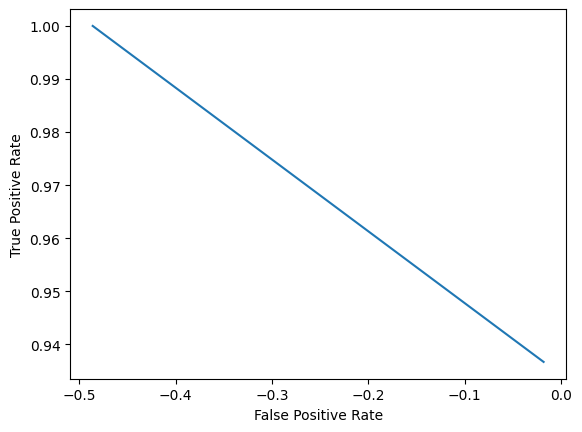

In [48]:
# import numpy as np
# import matplotlib.pyplot as plt
# Draw ROC curve
y_true=y_test

def roc_curve(y_true, y_pred):
    """
    Calculates the ROC curve for a binary classification model.

    Args:
        y_true: The ground truth labels.
        y_pred: The predicted labels.

    Returns:
        The ROC curve as a list of (FPR, TPR) tuples.
    """

    fpr = []
    tpr = []
    for threshold in np.arange(0, 1, 0.01):
        tp = np.sum(y_true & (y_pred >= threshold))
        fp = np.sum(~y_true & (y_pred >= threshold))
        fpr.append(fp / np.sum(~y_true))
        tpr.append(tp / np.sum(y_true))
    return fpr, tpr

fpr, tpr = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create the Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameters to tune and their possible values
param_grid = {
    # 'n_estimators': [100, 200, 300],  # Number of trees in the forest
    # 'max_depth': [None, 5, 10],  # Maximum depth of each tree
    # 'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    # 'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters found
best_params = grid_search.best_params_

# Create a new Random Forest Classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(**best_params)

# Fit the best model to the training data
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)

# Pipeline/s

In [ ]:
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
## Numerical Pipeline
num_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='mode')),
    ('scaler',StandardScaler())
    ]
)

In [ ]:
preprocessor=ColumnTransformer([
('num_pipeline',num_pipeline,numerical_features),
])

In [ ]:
a = [
    'directory_length', 'time_domain_activation', 'length_url',
    'file_length', 'qty_slash_url', 'qty_plus_directory',
    'domain_length', 'qty_vowels_domain', 'qty_asterisk_directory',
    'qty_hyphen_directory', 'qty_dot_domain', 'qty_underline_directory',
    'qty_percent_directory', 'qty_dot_url', 'qty_hyphen_url',
    'qty_hyphen_file', 'qty_hyphen_domain', 'qty_params_length',
    'qty_underline_url', 'qty_tld_url', 'qty_plus_params',
    'qty_percent_url', 'qty_equal_params', 'qty_dot_params',
    'qty_percent_params', 'qty_underline_params'
]


In [ ]:
b=['qty_questionmark_directory',
                              'qty_slash_url',
                                'qty_dot_directory',
                                'qty_underline_directory',
                                'directory_length',
                                'qty_hyphen_file',
                                'length_url',
                                'qty_hyphen_directory',
                                'time_domain_activation',
                                'qty_questionmark_params',
                                'qty_equal_url',
                                'qty_dot_domain',
                                'qty_underline_params',
                                'file_length',
                                'qty_percent_directory',
                                'qty_slash_params',
                                'qty_dot_params',
                                'qty_hyphen_params',
                                'params_length',
                                'qty_tld_url',
                                'qty_hyphen_url',
                                'qty_underline_url',
                                'email_in_url'
                                ]

In [ ]:
common=[]

for x in a:
  for y in b:
    if x==y:
      common.append(x)

print(common)

In [ ]:
len(a)

In [ ]:
df=pd.read_csv("dataset_full.csv")

In [ ]:
common=[]

for x in df:
  for y in a:
    if x==y:
      common.append(x)

print(common)
print(len(common))

In [ ]:
remove_col=[]
for col in df.columns[:]:
  if col not in common:
    remove_col.append(col)
remove_col

In [ ]:
df.columns